In [ ]:
# scaling factors
V_MIN = 0 #km/h
V_MAX = 150 #km/h

In [595]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# files split into lists by month and day of week
oct_mwf = ['10', '11', '12', '17', '18', '19', '24', '25', '26']
oct_thu = ['13', '20', '27']
nov_mwf = ['01', '02', '07', '08', '09', '14', '15', '16', '21', '22', '23', '28', '29', '30']
nov_thu = ['03', '10', '17', '24']

# split dataset into batches (see 2b_processing for more details on date selection)
two_week_no_test = [('11',nov_thu[-2])] + [('11',date) for date in nov_mwf[5:-3]]
all_thu_no_test = [('10',date) for date in oct_thu] + [('11',date) for date in nov_thu[:-1]]
all_weekdays_no_test = [('10',date) for date in oct_mwf+oct_thu] + [('11',date) for date in nov_mwf[:-3]+nov_thu[:-1]]

all_thu = [('10',date) for date in oct_thu] + [('11',date) for date in nov_thu]
all_weekdays = [('10',date) for date in oct_mwf+oct_thu] + [('11',date) for date in nov_mwf+nov_thu]

model_check_dates = [('10',date) for date in oct_thu]

val_thu = [('11',nov_thu[-1])]
val_thu

[('11', '24')]

# "Neural Net" Construction

Network architecture is described in paper. Essentially we take the average speed over the current and prior 5-minute interval for movements in the northbound (NB) or southbound (SB) directions to get a first estimate for the speed in the area of study. Then we mix in the speeds on the east-west feeder links to produce an improved second estimate. Finally we mix the prior interval and the speed on the oppositely-bounded link in order to create our final estimate for the speed in the study area.

## Network design heuristics

We used these heuristics to construct the portions of our network not directly inspired by physical characteristics:
* 1 hidden layer (per prediction) with nodes equal to the average of input size and output size.
* Rectified Linear Units (relus) for outputs which takes the maximum of each value against 0.
* Initialized all weights to be a uniform value between 0 and the square root of the number of inputs.
The latter two heuristics are justified by all inputs (speeds and speed estimates) being greater than zero and the network essentially performing a nonlinear averaging of the different inputs to produce a final estimate for the speed in the study area. PyTorch defaults to a random uniform initialization between the negative and positive values of the square root of the number of inputs but in an averaging all components should have zero or greater effect on the final average. We tested with the possibility of negative link weights but that tended to "kill" a large portion of links and produce a very poor fit.

In [305]:
class TRANSFOR_SPARTA_Net(torch.nn.Module):
    def __init__(self, name="", dir_moves_hidden=5, mix_we_pred1_hidden=5, mix_avg_last_b_hidden=2):
        super(TRANSFOR_SPARTA_Net, self).__init__()
    
        # mix northbound movements from t and (t-1) timesteps together for nb speed prediction #1
        self.nb_moves_t_tm1 = torch.nn.Linear(10,dir_moves_hidden)
        self.nb_pred1 = torch.nn.Linear(dir_moves_hidden,1)
        
        # mix nb speed pred #1 with east-west speeds for nb speed prediction #2
        self.nb_we_pred1_mix = torch.nn.Linear(9,mix_we_pred1_hidden)
        self.nb_pred2 = torch.nn.Linear(mix_we_pred1_hidden,1)
        
        # mix last timestep's prediction and sb speed prediction #2 for final nb speed prediction #3
        self.nb_pred2_avg_last_mix = torch.nn.Linear(3, mix_avg_last_b_hidden)
        self.nb_pred3 = torch.nn.Linear(mix_avg_last_b_hidden,1)
    
        ## symmetrical for southbound
        
        # mix southbound movements from t and (t-1) timesteps together for sb speed prediction #1
        self.sb_moves_t_tm1 = torch.nn.Linear(10,dir_moves_hidden)
        self.sb_pred1 = torch.nn.Linear(dir_moves_hidden,1)
        
        # mix sb speed pred #1 with east-west speeds for sb speed prediction #2
        self.sb_we_pred1_mix = torch.nn.Linear(9,mix_we_pred1_hidden)
        self.sb_pred2 = torch.nn.Linear(mix_we_pred1_hidden,1)
        
        # mix last timestep's prediction and nb speed prediction #2 for final sb speed prediction #3
        self.sb_pred2_avg_last_mix = torch.nn.Linear(3, mix_avg_last_b_hidden)
        self.sb_pred3 = torch.nn.Linear(mix_avg_last_b_hidden,1)
        
        ## initialize weights: force them all to initialize as positive
#         self.nb_moves_t_tm1.weight = torch.nn.Parameter(np.sqrt(10)*torch.rand(self.nb_moves_t_tm1.weight.shape))
#         self.nb_pred1.weight = torch.nn.Parameter(np.sqrt(dir_moves_hidden)*torch.rand(self.nb_pred1.weight.shape))
#         self.nb_we_pred1_mix.weight = torch.nn.Parameter(np.sqrt(9)*torch.rand(self.nb_we_pred1_mix.weight.shape))
#         self.nb_pred2.weight = torch.nn.Parameter(np.sqrt(mix_we_pred1_hidden)*torch.rand(self.nb_pred2.weight.shape))
#         self.nb_pred2_avg_last_mix.weight = torch.nn.Parameter(np.sqrt(3)*torch.rand(self.nb_pred2_avg_last_mix.weight.shape))
#         self.nb_pred3.weight = torch.nn.Parameter(np.sqrt(mix_avg_last_b_hidden)*torch.rand(self.nb_pred3.weight.shape))
#         self.sb_moves_t_tm1.weight = torch.nn.Parameter(np.sqrt(10)*torch.rand(self.sb_moves_t_tm1.weight.shape))
#         self.sb_pred1.weight = torch.nn.Parameter(np.sqrt(dir_moves_hidden)*torch.rand(self.sb_pred1.weight.shape))
#         self.sb_we_pred1_mix.weight = torch.nn.Parameter(np.sqrt(9)*torch.rand(self.sb_we_pred1_mix.weight.shape))
#         self.sb_pred2.weight = torch.nn.Parameter(np.sqrt(mix_we_pred1_hidden)*torch.rand(self.sb_pred2.weight.shape))
#         self.sb_pred2_avg_last_mix.weight = torch.nn.Parameter(np.sqrt(3)*torch.rand(self.sb_pred2_avg_last_mix.weight.shape))
#         self.sb_pred3.weight = torch.nn.Parameter(np.sqrt(mix_avg_last_b_hidden)*torch.rand(self.sb_pred3.weight.shape))

#         self.nb_moves_t_tm1.weight = torch.nn.Parameter(torch.rand(self.nb_moves_t_tm1.weight.shape))
#         self.nb_pred1.weight = torch.nn.Parameter(torch.rand(self.nb_pred1.weight.shape))
#         self.nb_we_pred1_mix.weight = torch.nn.Parameter(torch.rand(self.nb_we_pred1_mix.weight.shape))
#         self.nb_pred2.weight = torch.nn.Parameter(torch.rand(self.nb_pred2.weight.shape))
#         self.nb_pred2_avg_last_mix.weight = torch.nn.Parameter(torch.rand(self.nb_pred2_avg_last_mix.weight.shape))
#         self.nb_pred3.weight = torch.nn.Parameter(torch.rand(self.nb_pred3.weight.shape))
#         self.sb_moves_t_tm1.weight = torch.nn.Parameter(torch.rand(self.sb_moves_t_tm1.weight.shape))
#         self.sb_pred1.weight = torch.nn.Parameter(torch.rand(self.sb_pred1.weight.shape))
#         self.sb_we_pred1_mix.weight = torch.nn.Parameter(torch.rand(self.sb_we_pred1_mix.weight.shape))
#         self.sb_pred2.weight = torch.nn.Parameter(torch.rand(self.sb_pred2.weight.shape))
#         self.sb_pred2_avg_last_mix.weight = torch.nn.Parameter(torch.rand(self.sb_pred2_avg_last_mix.weight.shape))
#         self.sb_pred3.weight = torch.nn.Parameter(torch.rand(self.sb_pred3.weight.shape))

        self.nb_moves_t_tm1.weight = torch.nn.Parameter(torch.rand(self.nb_moves_t_tm1.weight.shape)/np.sqrt(10))
        self.nb_pred1.weight = torch.nn.Parameter(torch.rand(self.nb_pred1.weight.shape)/np.sqrt(dir_moves_hidden))
        self.nb_we_pred1_mix.weight = torch.nn.Parameter(torch.rand(self.nb_we_pred1_mix.weight.shape)/np.sqrt(9))
        self.nb_pred2.weight = torch.nn.Parameter(torch.rand(self.nb_pred2.weight.shape)/np.sqrt(mix_we_pred1_hidden))
        self.nb_pred2_avg_last_mix.weight = torch.nn.Parameter(torch.rand(self.nb_pred2_avg_last_mix.weight.shape)/np.sqrt(3))
        self.nb_pred3.weight = torch.nn.Parameter(torch.rand(self.nb_pred3.weight.shape)/np.sqrt(mix_avg_last_b_hidden))
        self.sb_moves_t_tm1.weight = torch.nn.Parameter(torch.rand(self.sb_moves_t_tm1.weight.shape)/np.sqrt(10))
        self.sb_pred1.weight = torch.nn.Parameter(torch.rand(self.sb_pred1.weight.shape)/np.sqrt(dir_moves_hidden))
        self.sb_we_pred1_mix.weight = torch.nn.Parameter(torch.rand(self.sb_we_pred1_mix.weight.shape)/np.sqrt(9))
        self.sb_pred2.weight = torch.nn.Parameter(torch.rand(self.sb_pred2.weight.shape)/np.sqrt(mix_we_pred1_hidden))
        self.sb_pred2_avg_last_mix.weight = torch.nn.Parameter(torch.rand(self.sb_pred2_avg_last_mix.weight.shape)/np.sqrt(3))
        self.sb_pred3.weight = torch.nn.Parameter(torch.rand(self.sb_pred3.weight.shape)/np.sqrt(mix_avg_last_b_hidden))

    def forward(self, 
                nb_moves_t, 
                nb_moves_tm1, 
                sb_moves_t, 
                sb_moves_tm1, 
                ew_moves_t, 
                ew_moves_tm1,
                nb_hat_tm1, 
                sb_hat_tm1):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        
        # clamp all predictions to 0 because we know that neither northbound or southbound speed will ever move backward
        # as well as to introduce nonlinearity to neural net
        
        # northbound up to pred2
        # mix northbound movements from t and (t-1) timesteps together for nb speed prediction #1
        nb_moves_t_tm1 = self.nb_moves_t_tm1(torch.cat([nb_moves_t, nb_moves_tm1])).clamp(min=0)
        nb_pred1 = self.nb_pred1(nb_moves_t_tm1).clamp(min=0)
        
        # mix nb speed pred #1 with east-west speeds for nb speed prediction #2
        nb_we_pred1_mix = self.nb_we_pred1_mix(torch.cat([nb_pred1, ew_moves_t, ew_moves_tm1])).clamp(min=0)
        nb_pred2 = self.nb_pred2(nb_we_pred1_mix).clamp(min=0)
        
        # southbound up to pred2
        
        # mix southbound movements from t and (t-1) timesteps together for sb speed prediction #1
        sb_moves_t_tm1 = self.sb_moves_t_tm1(torch.cat([sb_moves_t, sb_moves_tm1])).clamp(min=0)
        sb_pred1 = self.sb_pred1(sb_moves_t_tm1).clamp(min=0)
        
        # mix sb speed pred #1 with east-west speeds for sb speed prediction #2
        sb_we_pred1_mix = self.sb_we_pred1_mix(torch.cat([sb_pred1, ew_moves_t, ew_moves_tm1])).clamp(min=0)
        sb_pred2 = self.sb_pred2(sb_we_pred1_mix).clamp(min=0)
        
        # final prediction: mix both pred2 with each other
        
        # mix last timestep's prediction and nb & sb speed prediction #2
        nb_pred2_avg_last_mix = self.nb_pred2_avg_last_mix(torch.cat([nb_pred2, nb_hat_tm1, sb_pred2])).clamp(min=0)
        nb_pred3 = self.nb_pred3(nb_pred2_avg_last_mix).clamp(min=0)
        
        # mix last timestep's prediction and sb & nb speed prediction #2
        sb_pred2_avg_last_mix = self.sb_pred2_avg_last_mix(torch.cat([sb_pred2, sb_hat_tm1, nb_pred2])).clamp(min=0)
        sb_pred3 = self.sb_pred3(sb_pred2_avg_last_mix).clamp(min=0)
        
        return nb_pred3, sb_pred3

# Training the Model

## Training Methods

### 1. "Batched" Training

Mimics test conditions by taking the RMSE across an entire day and then updating the weights. Also doubles as our validation and test method if am and pm models aren't split.

In [696]:
def model_using(dates, model=None, am=True, pm=True, op='train', epochs=1, lr=1e-4, momentum=0, dampening=0, weight_decay=0, nesterov=False, verbose=True):
    # if testing or validating split am/pm model, model is am model, model_pm is pm model
    # momentum, dampening, weight_decay, and nesterov are all from the pytorch implementation of stochastic gradient descent (SGD)
    
    if (op not in {'train', 'validate', 'test'}):
        raise ValueError('Can only do train, validate, or test ops')
    if (op in {'test', 'validate'}) and (model==None):
        raise ValueError('Can\'t validate/test without a model')
    if (not am) and (not pm):
        raise ValueError('Need either or both am and pm flags set to True') 
        
    ampm = []
    if am:
        ampm.append('am')
    if pm:
        ampm.append('pm')
        
    if not model:
        model = TRANSFOR_SPARTA_Net().double()
    
    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
    
    rmse = []
    
    for epoch in range(epochs): # training runs over the full datasets
        
        if epoch == epochs-1: # log last set of training results
            daily_ytrues = []
            daily_predictions = []
        
        for date in dates:
            
            # collect results
            nb_preds = []
            sb_preds = []    
            
            ytrue = []
            
            # update weights only after a full day has been fitted
            for k,m in enumerate(ampm): 
                
                # read in data
                dfy = pd.read_pickle('data/processed/{}-{}_y_{}.pkl'.format(date[0],date[1],m))
                dfy = dfy.iloc[:-1,:] # drop last row
                
                dfn = pd.read_pickle('data/processed/{}-{}_n_{}.pkl'.format(date[0],date[1],m))
                dfs = pd.read_pickle('data/processed/{}-{}_s_{}.pkl'.format(date[0],date[1],m))
                dfew = pd.read_pickle('data/processed/{}-{}_ew_{}.pkl'.format(date[0],date[1],m))
                dfn = pd.read_pickle('data/processed/{}-{}_n_{}.pkl'.format(date[0],date[1],m))
                dfs = pd.read_pickle('data/processed/{}-{}_s_{}.pkl'.format(date[0],date[1],m))
                dfew = pd.read_pickle('data/processed/{}-{}_ew_{}.pkl'.format(date[0],date[1],m))
                
                # set first t-1 (tm1) 
                nb_moves_tm1 = torch.tensor(dfn.values[0,:])
                sb_moves_tm1 = torch.tensor(dfs.values[0,:])
                ew_moves_tm1 = torch.tensor(dfew.values[0,:])
                nb_hat_tm1 = torch.tensor([dfy.values[0,0]]).double()
                sb_hat_tm1 = torch.tensor([dfy.values[0,1]]).double()
                                
                # drop first entry and convert y of true values to tensor
                if op in {'train', 'validate'}:
                    dfy = dfy.iloc[1:,:]
#                     print('dfy', dfy.head())
                    ytrue.append(dfy.values)
#                     print('ytrue in loop', ytrue[0:10])
                
                for i in range(1,61): # fixed five-hour period cut into 5 minute chunks

                    # get data
                    nb_moves_t = torch.tensor(dfn.values[i,:])
                    sb_moves_t = torch.tensor(dfs.values[i,:])
                    ew_moves_t = torch.tensor(dfew.values[i,:])
                    
                    # fit model
                    nb_pred, sb_pred = model(
                        nb_moves_t, 
                        nb_moves_tm1, 
                        sb_moves_t, 
                        sb_moves_tm1, 
                        ew_moves_t, 
                        ew_moves_tm1,
                        nb_hat_tm1, 
                        sb_hat_tm1
                    )
                    
                    # collect predictions
                    nb_preds.append(nb_pred)
                    sb_preds.append(sb_pred)
                    
                    # set next set of (t-1) values
                    nb_moves_tm1 = nb_moves_t
                    sb_moves_tm1 = sb_moves_t
                    ew_moves_tm1 = ew_moves_t
                    nb_hat_tm1 = nb_pred
                    sb_hat_tm1 = sb_pred
            
            
#             print('nb_preds', nb_preds[0:10])
#             print('sb_preds', sb_preds[0:10])
            # combine morning and evening southbound and northbound predictions
            preds = torch.cat(nb_preds+sb_preds)
            if op in {'train', 'validate'}:
                ytrue = torch.tensor(np.stack(ytrue).T.flatten())
                loss = torch.sqrt(criterion(preds, ytrue))
            
            if op == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            if op in {'train', 'validate'}:
                rmse.append(loss.item())

            if epoch == epochs-1:
                if op in {'train', 'validate'}:
                    daily_ytrues.append(ytrue.detach().numpy())
                daily_predictions.append(preds.detach().numpy())
        
        if op=='train' and verbose:
            print('Epoch {}, Last date RMSE {}'.format(epoch+1, loss.item()))
    
    if op in {'train', 'validate'}:
        return model, rmse, daily_ytrues, daily_predictions
    else:
        return daily_predictions

In [544]:
model1, rmse1, ytrues1, preds1 = model_using(model_check_dates,op='train',epochs=20,lr=1e-4)

Epoch 0, Last date RMSE 129.5732053825166
Epoch 1, Last date RMSE 118.71149170217471
Epoch 2, Last date RMSE 118.33513905348829
Epoch 3, Last date RMSE 118.14333604101768
Epoch 4, Last date RMSE 117.96057031046288
Epoch 5, Last date RMSE 117.78101889931678
Epoch 6, Last date RMSE 117.60437326922899
Epoch 7, Last date RMSE 117.4305333193995
Epoch 8, Last date RMSE 117.25941248726042
Epoch 9, Last date RMSE 117.090930340714
Epoch 10, Last date RMSE 116.92501189378788
Epoch 11, Last date RMSE 116.76158718802877
Epoch 12, Last date RMSE 116.60059091430772
Epoch 13, Last date RMSE 116.44196206431792
Epoch 14, Last date RMSE 116.28564360852187
Epoch 15, Last date RMSE 116.13158219789503
Epoch 16, Last date RMSE 115.97972788713979
Epoch 17, Last date RMSE 115.83003387732737
Epoch 18, Last date RMSE 115.68245627616885
Epoch 19, Last date RMSE 115.53695387433785


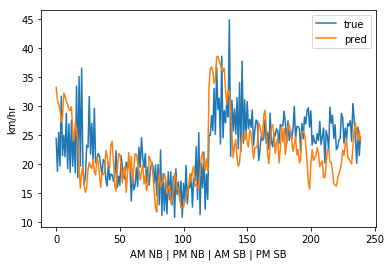

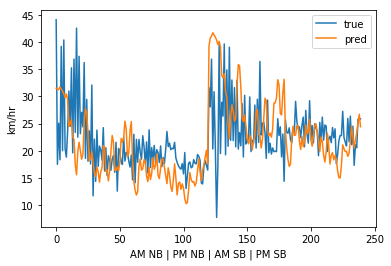

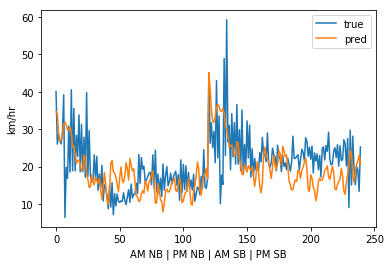

In [585]:
def plot_comparison(ytrues, ypreds, title=None):
    for i in range(len(ytrues)):
        plt.plot(ytrues[i], label='true')
        plt.plot(ypreds[i], label='pred')
        plt.legend()
        plt.ylabel('km/hr')
        plt.xlabel('AM NB | PM NB | AM SB | PM SB')
        if title:
            plt.title(title)
        plt.show()
plot_comparison(ytrues1, preds1)

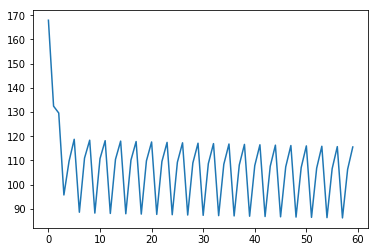

In [546]:
plt.plot(rmse1)
plt.show()

### 2. "Online" training

Update the weights on every new row (5 minute interval).

In [581]:
def online_training(dates, model=None, am=True, pm=True, op='train', epochs=1, lr=1e-4, momentum=0, dampening=0, weight_decay=0, nesterov=False, verbose=True):
    # if testing or validating split am/pm model, model is am model, model_pm is pm model
    
    if (op not in {'train', 'validate', 'test'}):
        raise ValueError('Can only do train, validate, or test ops')
    if (op in {'test', 'validate'}) and (model==None):
        raise ValueError('Can\'t validate/test without a model')
    if (not am) and (not pm):
        raise ValueError('Need either or both am and pm flags set to True') 
      
    ampm = []
    if am:
        ampm.append('am')
    if pm:
        ampm.append('pm')
        
    if not model:
        model = TRANSFOR_SPARTA_Net().double()
    
    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the model.
    criterion = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
    
    for epoch in range(epochs): # training runs over the full datasets
        
        if epoch == epochs-1:
            daily_ytrues = []
            daily_predictions = []
        
        for date in dates:
            
            # collect results
            nb_preds = []
            sb_preds = []    
            
            ytrue = []
            
            # temp check
            nb_dts = []
            sb_dts = []
            ytdts = []
            
            # update weights only after a full day has been fitted
            for m in ampm:            
                
                # read in data
                dfy = pd.read_pickle('data/processed/{}-{}_y_{}.pkl'.format(date[0],date[1],m))
                dfy = dfy.iloc[:-1,:] # drop last row
                
                dfn = pd.read_pickle('data/processed/{}-{}_n_{}.pkl'.format(date[0],date[1],m))
                dfs = pd.read_pickle('data/processed/{}-{}_s_{}.pkl'.format(date[0],date[1],m))
                dfew = pd.read_pickle('data/processed/{}-{}_ew_{}.pkl'.format(date[0],date[1],m))
                dfn = pd.read_pickle('data/processed/{}-{}_n_{}.pkl'.format(date[0],date[1],m))
                dfs = pd.read_pickle('data/processed/{}-{}_s_{}.pkl'.format(date[0],date[1],m))
                dfew = pd.read_pickle('data/processed/{}-{}_ew_{}.pkl'.format(date[0],date[1],m))
                
                # set first t-1 (tm1) 
                nb_moves_tm1 = torch.tensor(dfn.values[0,:])
                sb_moves_tm1 = torch.tensor(dfs.values[0,:])
                ew_moves_tm1 = torch.tensor(dfew.values[0,:])
                nb_hat_tm1 = torch.tensor([dfy.values[0,0]]).double()
                sb_hat_tm1 = torch.tensor([dfy.values[0,1]]).double()
                                
                # drop first entry and convert y of true values to tensor
                ytrue.append(torch.tensor(dfy.iloc[1:,:].values))
#                     print('ytrue in loop', ytrue[0:10])
                ytdts.append(dfy.index[1:])
    
                nb_dt = []
                sb_dt = []
                
                for i in range(1,61): # fixed five-hour period cut into 5 minute chunks

                    # get data
                    nb_moves_t = torch.tensor(dfn.values[i,:])
                    sb_moves_t = torch.tensor(dfs.values[i,:])
                    ew_moves_t = torch.tensor(dfew.values[i,:])
                    
                    # fit model
                    nb_pred, sb_pred = model(
                        nb_moves_t, 
                        nb_moves_tm1, 
                        sb_moves_t, 
                        sb_moves_tm1, 
                        ew_moves_t, 
                        ew_moves_tm1,
                        nb_hat_tm1, 
                        sb_hat_tm1
                    )
                    
                    # update weights
                    loss = torch.sqrt(criterion(
                        torch.cat([nb_pred, sb_pred]), 
                        torch.tensor(dfy.values[i,:])
                    ))
                    optimizer.zero_grad()
                    loss.backward(retain_graph=True)
                    optimizer.step()
                    
                    # collect predictions
                    nb_preds.append(nb_pred)
                    sb_preds.append(sb_pred)
                    
                    # temp check
#                     nb_dt.append(dfn.index[i])
#                     sb_dt.append(dfs.index[i])
                    
                    # set next set of (t-1) values
                    nb_moves_tm1 = nb_moves_t
                    sb_moves_tm1 = sb_moves_t
                    ew_moves_tm1 = ew_moves_t
                    nb_hat_tm1 = nb_pred
                    sb_hat_tm1 = sb_pred                    
            
#                 nb_dts.append(nb_dt)
#                 sb_dts.append(sb_dt)
#             print('nb_preds', nb_preds[0:10])
#             print('sb_preds', sb_preds[0:10])
            # combine morning and evening southbound and northbound predictions
            preds = torch.cat(nb_preds+sb_preds)
            ytrue = np.stack(ytrue).T.flatten()
            
#             print('ytrue', ytrue[0:10])
#             print('preds', preds[0:10])
            
            rmse.append(loss.item())

            if epoch == epochs-1:
                daily_ytrues.append(ytrue)
                daily_predictions.append(preds.detach().numpy())
        
        if verbose:
            print('Epoch {}, Last timestep RMSE {}'.format(epoch+1, loss.item()))
    
    
    return model, rmse, daily_ytrues, daily_predictions
#     return model, rmse, ytrue.detach().numpy(), preds.detach().numpy(), nb_dts, sb_dts, ytdts

In [582]:
model2, rmse, ytrues2, preds2 = online_training(model_check_dates, epochs=10, lr=1e-4)

Epoch 1, Last timestep RMSE 3.716540122046345
Epoch 2, Last timestep RMSE 2.019121483662317
Epoch 3, Last timestep RMSE 1.9408245021009438
Epoch 4, Last timestep RMSE 1.9099043005753698
Epoch 5, Last timestep RMSE 1.884588158658704
Epoch 6, Last timestep RMSE 1.8611531796091356
Epoch 7, Last timestep RMSE 1.8388244219489707
Epoch 8, Last timestep RMSE 1.8174294360315182
Epoch 9, Last timestep RMSE 1.796944891919645
Epoch 10, Last timestep RMSE 1.7773952518703326
Epoch 11, Last timestep RMSE 1.758823236039671
Epoch 12, Last timestep RMSE 1.741274400799356
Epoch 13, Last timestep RMSE 1.7247850859655034
Epoch 14, Last timestep RMSE 1.7093723289281548
Epoch 15, Last timestep RMSE 1.6950262901166064
Epoch 16, Last timestep RMSE 1.681706515558386
Epoch 17, Last timestep RMSE 1.6693437129095958
Epoch 18, Last timestep RMSE 1.6578481827871878
Epoch 19, Last timestep RMSE 1.647124291908169
Epoch 20, Last timestep RMSE 1.6370879001667924


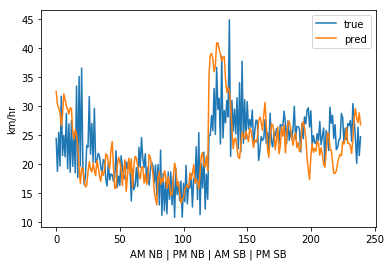

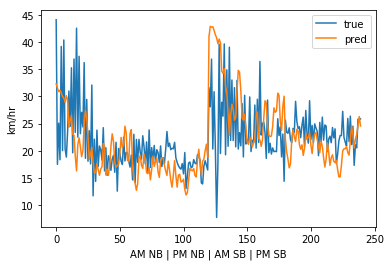

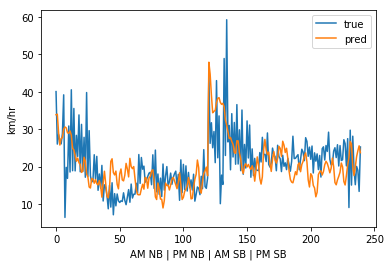

In [583]:
plot_comparison(ytrues2, preds2)

## Model choice and hyperparameter tuning

Here we'll try and decide
* How many epochs (training runs over the dataset) to use
* What learning rate (how fast the SGD moves) to use
* If we should introduce momentum (does gradient descent speed up when it's moving in a particular direction?) 
* If so, what momentum variation to use? (Regular or Nesterov?) [(more reading on this here)](http://ruder.io/optimizing-gradient-descent/index.html)
* Whether training over all Monday-Thursday weekdays or just Thursdays is better

We've reserved 11/24, the last Thursday in the dataset before the study day, Thursday 12/1, as the date we're validating against and all prior Thursdays in the dataset as well as the two weeks worth of Monday-Thursdays preceding 11/24 to train the model(s) with. This may result in overfitting against a single day.

 Daily Data(Th), LR(0.001), Epochs(1), no momentum RMSE: 295.2440371687854


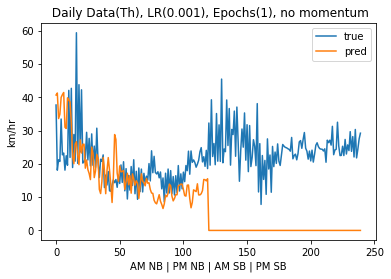

Online Data(Th), LR(0.001), Epochs(1), no momentum RMSE: 361.48573117571925


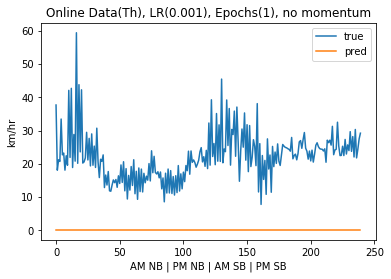

 Daily Data(Th), LR(0.001), Epochs(1), momentum RMSE: 357.8062452364981


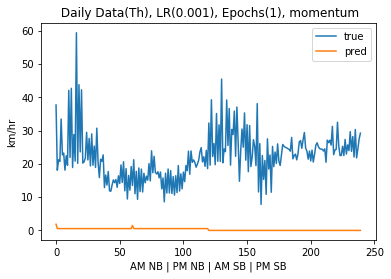

Online Data(Th), LR(0.001), Epochs(1), momentum RMSE: 292.606472843062


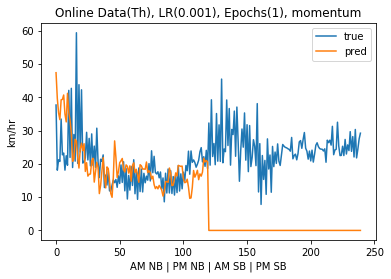

 Daily Data(Th), LR(0.001), Epochs(1), Nesterov momentum RMSE: 357.6795659699104


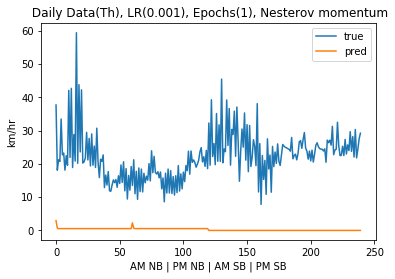

Online Data(Th), LR(0.001), Epochs(1), Nesterov momentum RMSE: nan


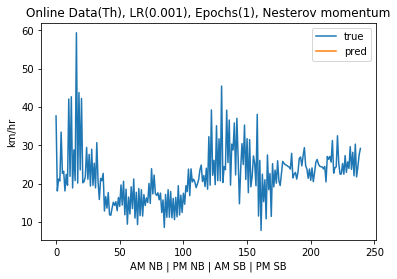

 Daily Data(Wk), LR(0.001), Epochs(1), no momentum RMSE: 335.2032936497296


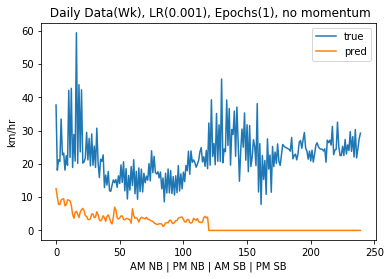

Online Data(Wk), LR(0.001), Epochs(1), no momentum RMSE: nan


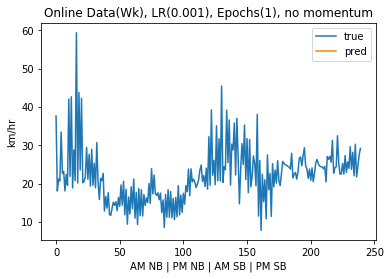

 Daily Data(Wk), LR(0.001), Epochs(1), momentum RMSE: 361.48573117571925


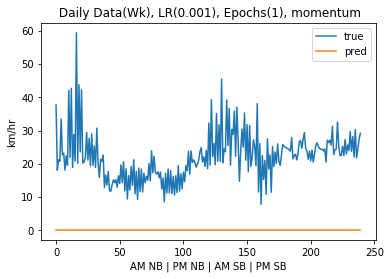

Online Data(Wk), LR(0.001), Epochs(1), momentum RMSE: nan


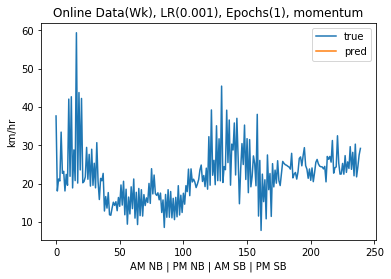

 Daily Data(Wk), LR(0.001), Epochs(1), Nesterov momentum RMSE: 361.48573117571925


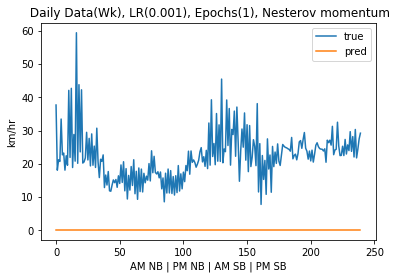

Online Data(Wk), LR(0.001), Epochs(1), Nesterov momentum RMSE: 179.11683385910226


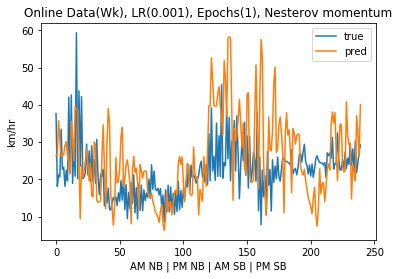

 Daily Data(Th), LR(0.0001), Epochs(1), no momentum RMSE: 155.07178007327605


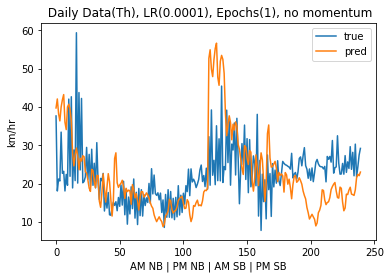

Online Data(Th), LR(0.0001), Epochs(1), no momentum RMSE: 171.1406251301537


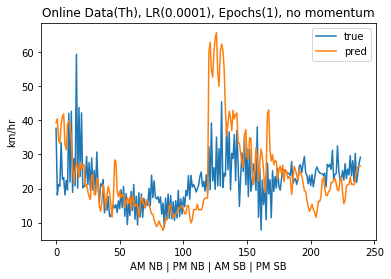

 Daily Data(Th), LR(0.0001), Epochs(1), momentum RMSE: 149.68583548619185


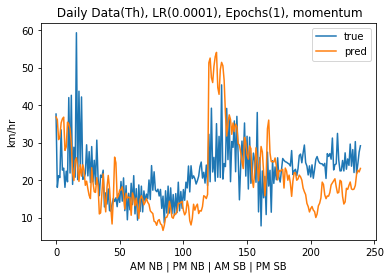

Online Data(Th), LR(0.0001), Epochs(1), momentum RMSE: 191.376108975211


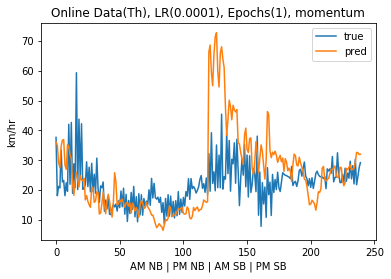

 Daily Data(Th), LR(0.0001), Epochs(1), Nesterov momentum RMSE: 189.18511691095026


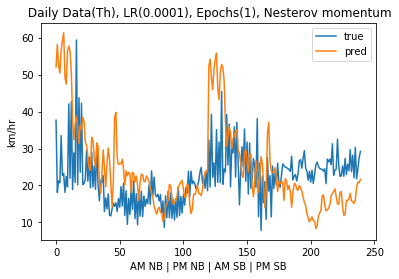

Online Data(Th), LR(0.0001), Epochs(1), Nesterov momentum RMSE: 166.49567656836754


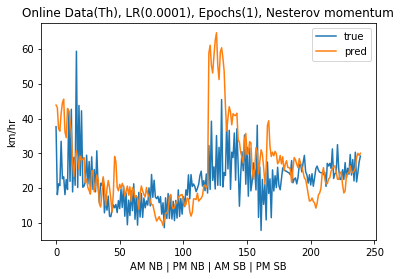

 Daily Data(Wk), LR(0.0001), Epochs(1), no momentum RMSE: 193.45676641646054


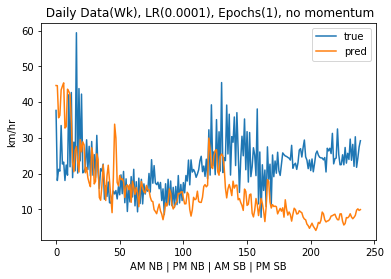

Online Data(Wk), LR(0.0001), Epochs(1), no momentum RMSE: 185.2930274912812


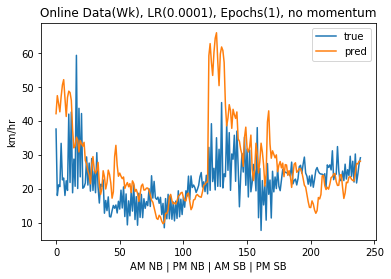

 Daily Data(Wk), LR(0.0001), Epochs(1), momentum RMSE: 215.73850425426562


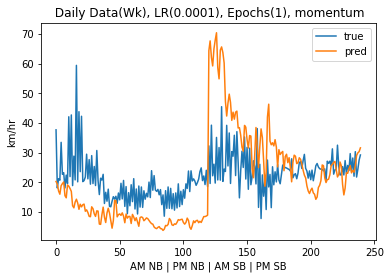

Online Data(Wk), LR(0.0001), Epochs(1), momentum RMSE: 144.08243381990852


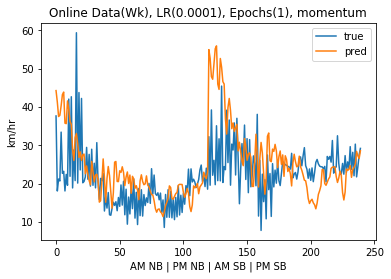

 Daily Data(Wk), LR(0.0001), Epochs(1), Nesterov momentum RMSE: 138.88993994097913


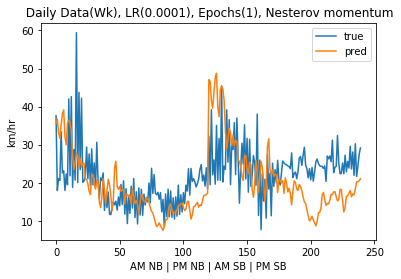

Online Data(Wk), LR(0.0001), Epochs(1), Nesterov momentum RMSE: 138.5263432852476


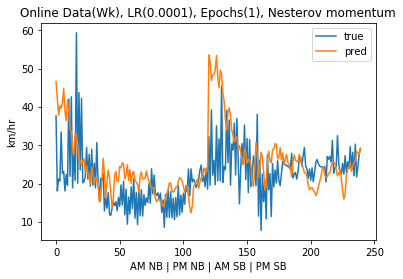

 Daily Data(Th), LR(1e-05), Epochs(1), no momentum RMSE: 205.7830573096073


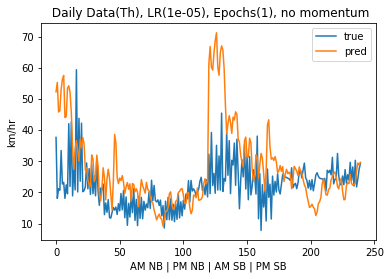

Online Data(Th), LR(1e-05), Epochs(1), no momentum RMSE: 163.07018218434172


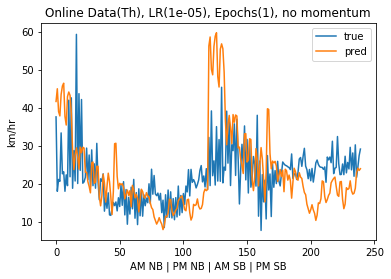

 Daily Data(Th), LR(1e-05), Epochs(1), momentum RMSE: 271.2183397936513


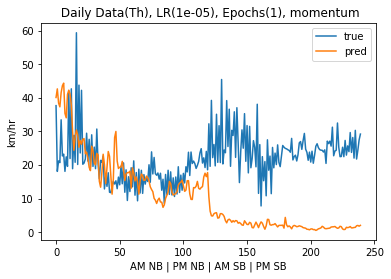

Online Data(Th), LR(1e-05), Epochs(1), momentum RMSE: 194.6345538940234


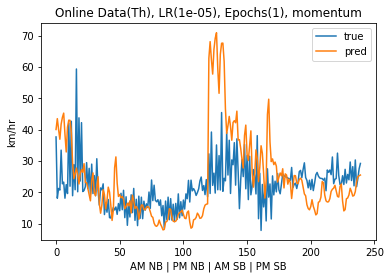

 Daily Data(Th), LR(1e-05), Epochs(1), Nesterov momentum RMSE: 228.13775920751613


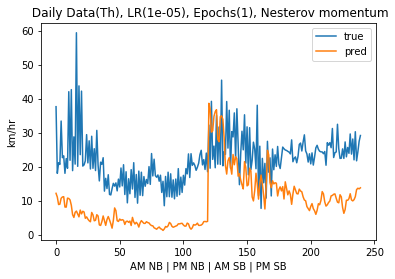

Online Data(Th), LR(1e-05), Epochs(1), Nesterov momentum RMSE: 154.61477809204573


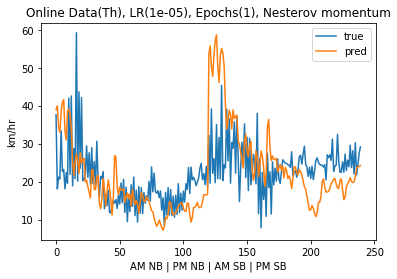

 Daily Data(Wk), LR(1e-05), Epochs(1), no momentum RMSE: 375.80770967279466


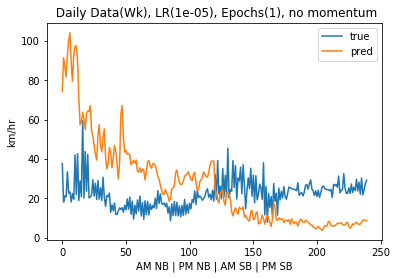

Online Data(Wk), LR(1e-05), Epochs(1), no momentum RMSE: 179.53971644505097


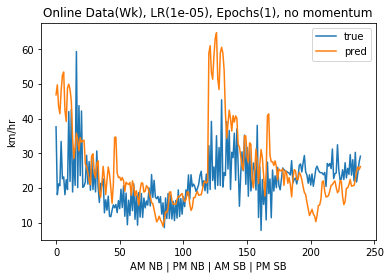

 Daily Data(Wk), LR(1e-05), Epochs(1), momentum RMSE: 174.72097648443915


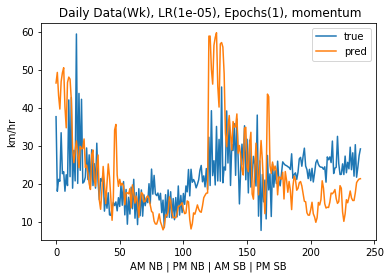

Online Data(Wk), LR(1e-05), Epochs(1), momentum RMSE: 207.95017320857158


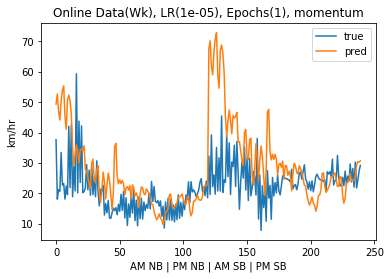

 Daily Data(Wk), LR(1e-05), Epochs(1), Nesterov momentum RMSE: 167.94329388518298


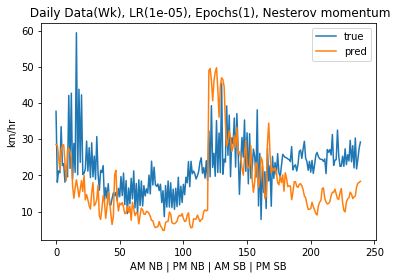

Online Data(Wk), LR(1e-05), Epochs(1), Nesterov momentum RMSE: 180.73049089836405


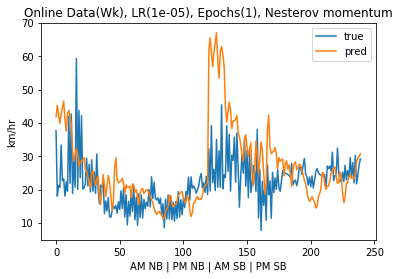

 Daily Data(Th), LR(0.001), Epochs(5), no momentum RMSE: 266.30887504463726


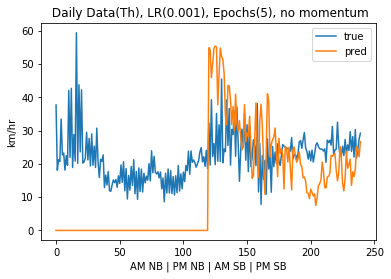

Online Data(Th), LR(0.001), Epochs(5), no momentum RMSE: 342.3721933396121


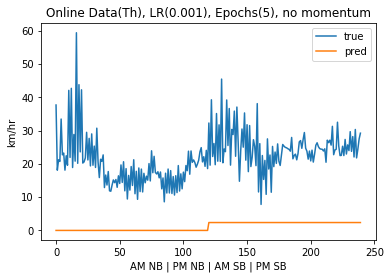

 Daily Data(Th), LR(0.001), Epochs(5), momentum RMSE: 361.36035456955767


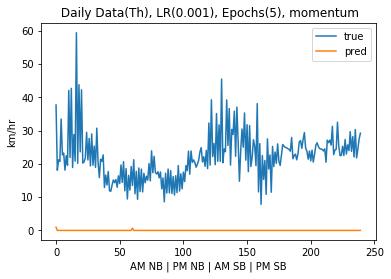

Online Data(Th), LR(0.001), Epochs(5), momentum RMSE: 144.063072609367


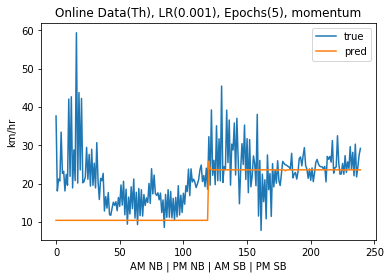

 Daily Data(Th), LR(0.001), Epochs(5), Nesterov momentum RMSE: 361.48573117571925


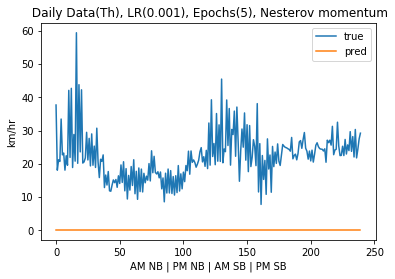

Online Data(Th), LR(0.001), Epochs(5), Nesterov momentum RMSE: nan


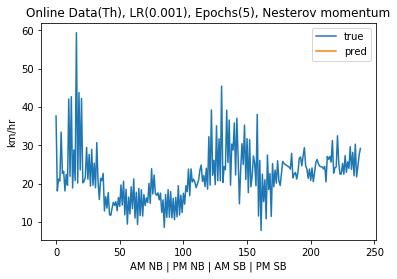

 Daily Data(Wk), LR(0.001), Epochs(5), no momentum RMSE: 213.02109119866682


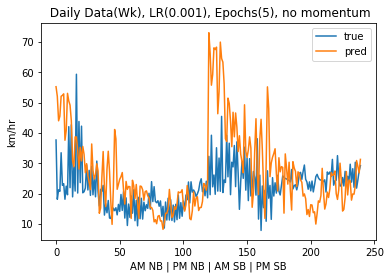

Online Data(Wk), LR(0.001), Epochs(5), no momentum RMSE: 361.48573117571925


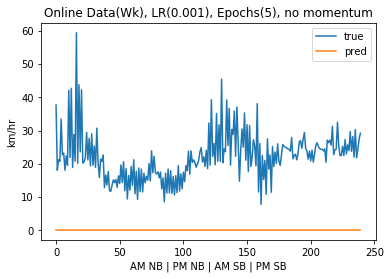

 Daily Data(Wk), LR(0.001), Epochs(5), momentum RMSE: 340.7031324859032


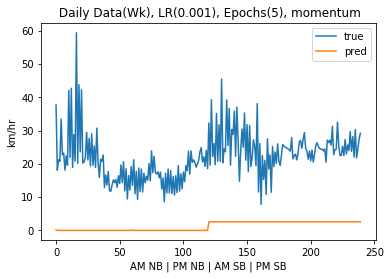

Online Data(Wk), LR(0.001), Epochs(5), momentum RMSE: 153.92721050696414


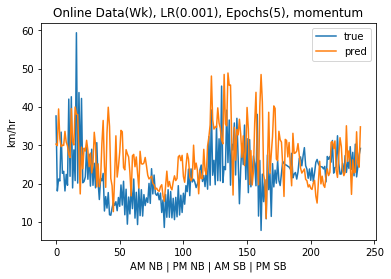

 Daily Data(Wk), LR(0.001), Epochs(5), Nesterov momentum RMSE: 361.48573117571925


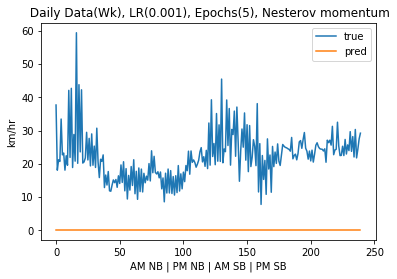

Online Data(Wk), LR(0.001), Epochs(5), Nesterov momentum RMSE: 106.51288379483859


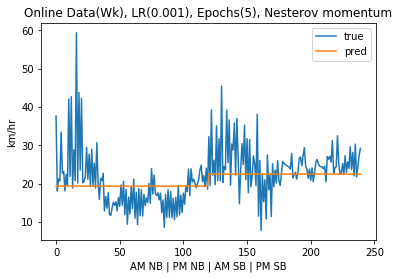

 Daily Data(Th), LR(0.0001), Epochs(5), no momentum RMSE: 154.4704069940858


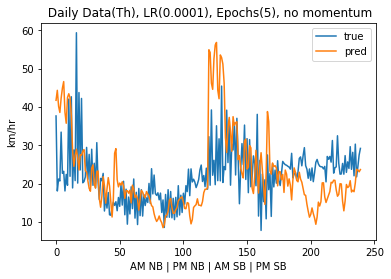

Online Data(Th), LR(0.0001), Epochs(5), no momentum RMSE: 132.25283285466512


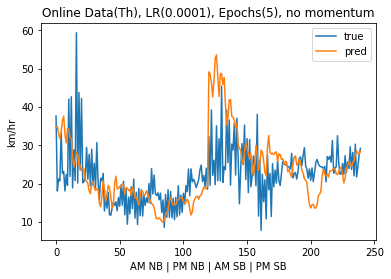

 Daily Data(Th), LR(0.0001), Epochs(5), momentum RMSE: 161.3687997700667


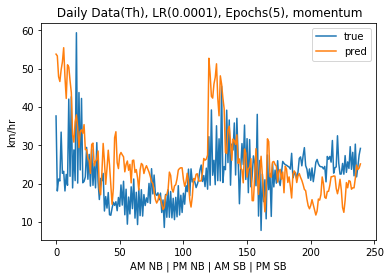

Online Data(Th), LR(0.0001), Epochs(5), momentum RMSE: 133.08767513789488


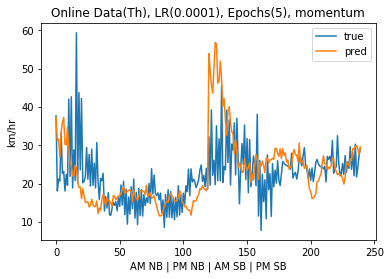

 Daily Data(Th), LR(0.0001), Epochs(5), Nesterov momentum RMSE: 137.74169787425814


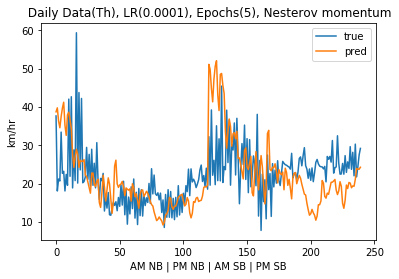

Online Data(Th), LR(0.0001), Epochs(5), Nesterov momentum RMSE: 127.42256446392514


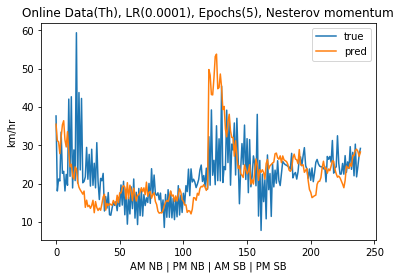

 Daily Data(Wk), LR(0.0001), Epochs(5), no momentum RMSE: 150.77257724140284


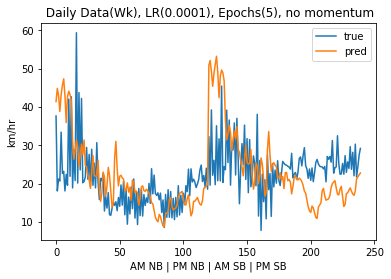

Online Data(Wk), LR(0.0001), Epochs(5), no momentum RMSE: 125.22535503438291


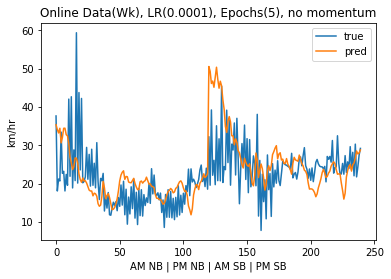

 Daily Data(Wk), LR(0.0001), Epochs(5), momentum RMSE: 171.73514643670762


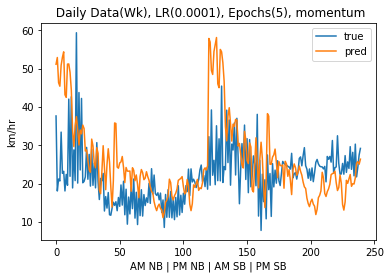

Online Data(Wk), LR(0.0001), Epochs(5), momentum RMSE: 123.72011246785848


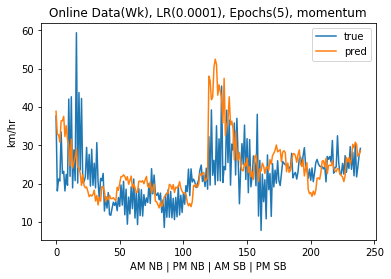

 Daily Data(Wk), LR(0.0001), Epochs(5), Nesterov momentum RMSE: 128.52374753414


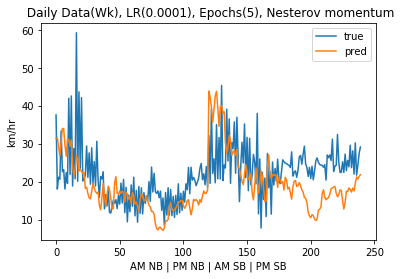

Online Data(Wk), LR(0.0001), Epochs(5), Nesterov momentum RMSE: 119.0018742714422


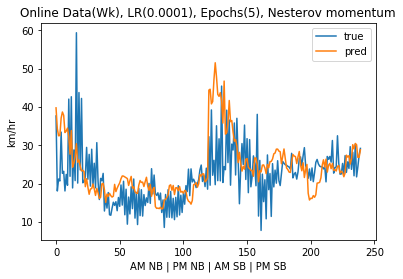

 Daily Data(Th), LR(1e-05), Epochs(5), no momentum RMSE: 193.97129092600412


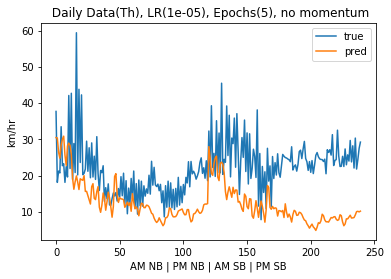

Online Data(Th), LR(1e-05), Epochs(5), no momentum RMSE: 143.3465018298825


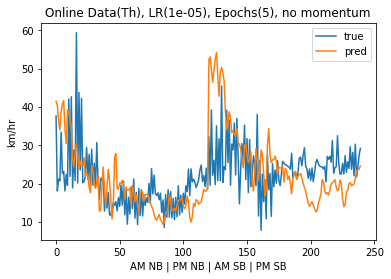

 Daily Data(Th), LR(1e-05), Epochs(5), momentum RMSE: 148.1889578268121


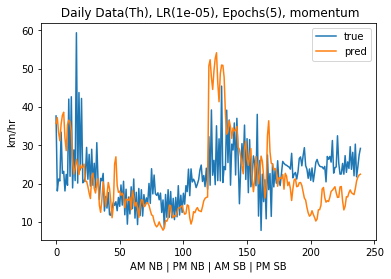

Online Data(Th), LR(1e-05), Epochs(5), momentum RMSE: 138.48572890166508


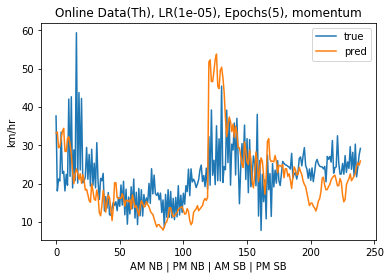

 Daily Data(Th), LR(1e-05), Epochs(5), Nesterov momentum RMSE: 156.15374102036085


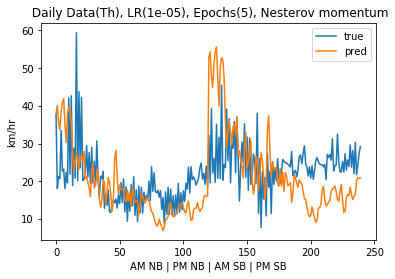

Online Data(Th), LR(1e-05), Epochs(5), Nesterov momentum RMSE: 135.13337846823944


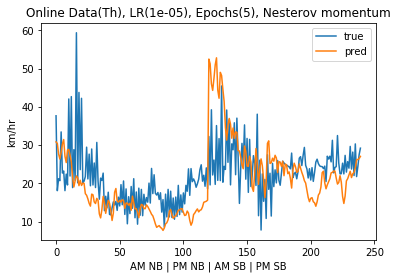

 Daily Data(Wk), LR(1e-05), Epochs(5), no momentum RMSE: 153.28075210884563


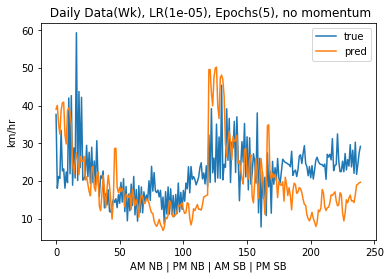

Online Data(Wk), LR(1e-05), Epochs(5), no momentum RMSE: 197.14487846984994


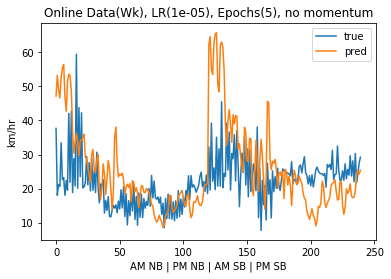

 Daily Data(Wk), LR(1e-05), Epochs(5), momentum RMSE: 156.61232591883171


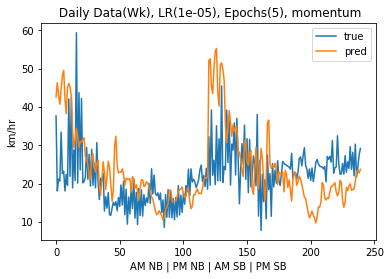

Online Data(Wk), LR(1e-05), Epochs(5), momentum RMSE: 137.54826751898923


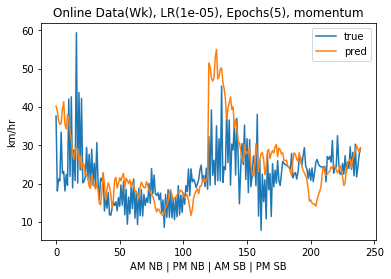

 Daily Data(Wk), LR(1e-05), Epochs(5), Nesterov momentum RMSE: 152.31274437714913


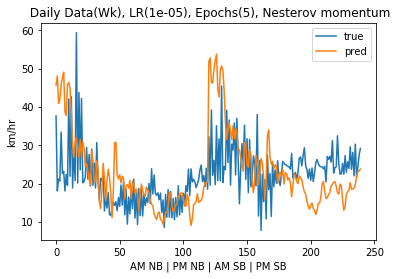

Online Data(Wk), LR(1e-05), Epochs(5), Nesterov momentum RMSE: 148.0742950003043


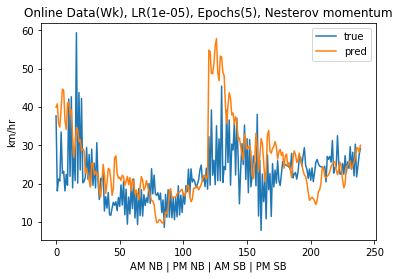

 Daily Data(Th), LR(0.001), Epochs(10), no momentum RMSE: 267.7871291724883


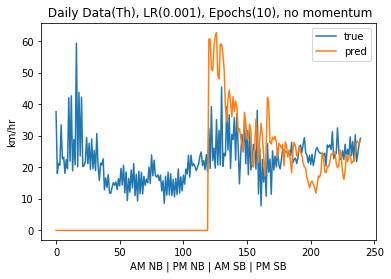

Online Data(Th), LR(0.001), Epochs(10), no momentum RMSE: 361.48573117571925


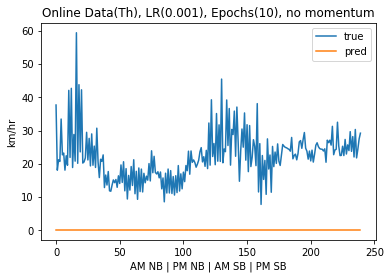

 Daily Data(Th), LR(0.001), Epochs(10), momentum RMSE: 361.48573117571925


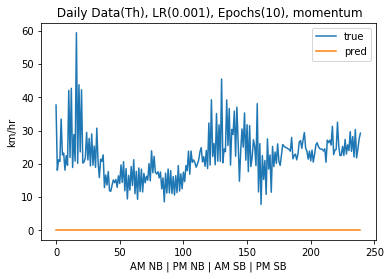

Online Data(Th), LR(0.001), Epochs(10), momentum RMSE: 361.48573117571925


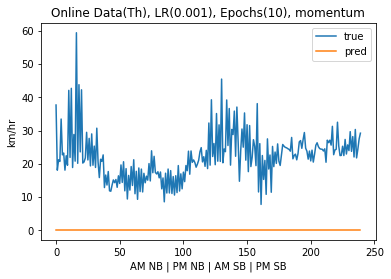

 Daily Data(Th), LR(0.001), Epochs(10), Nesterov momentum RMSE: 361.48573117571925


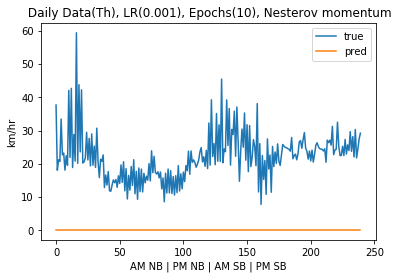

Online Data(Th), LR(0.001), Epochs(10), Nesterov momentum RMSE: nan


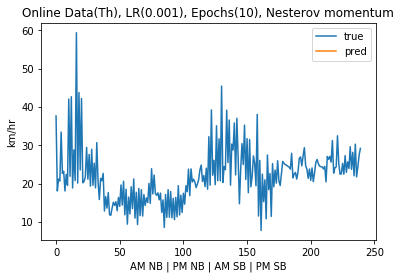

 Daily Data(Wk), LR(0.001), Epochs(10), no momentum RMSE: 354.78118341501073


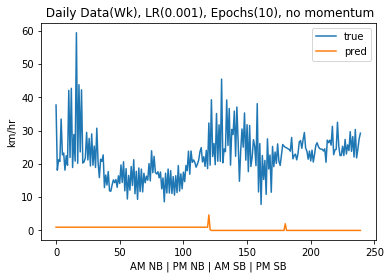

Online Data(Wk), LR(0.001), Epochs(10), no momentum RMSE: 361.48573117571925


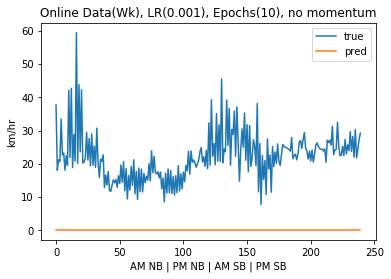

 Daily Data(Wk), LR(0.001), Epochs(10), momentum RMSE: 339.2926598650205


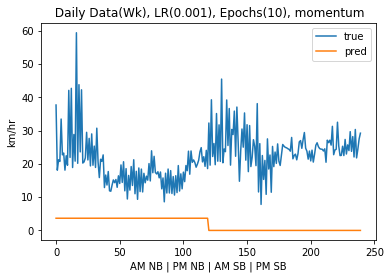

Online Data(Wk), LR(0.001), Epochs(10), momentum RMSE: 137.20959520190547


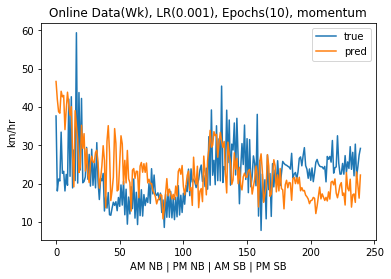

 Daily Data(Wk), LR(0.001), Epochs(10), Nesterov momentum RMSE: 323.7658631180128


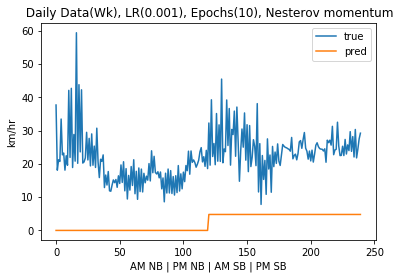

Online Data(Wk), LR(0.001), Epochs(10), Nesterov momentum RMSE: 361.48573117571925


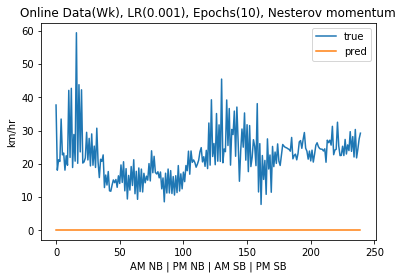

 Daily Data(Th), LR(0.0001), Epochs(10), no momentum RMSE: 148.8062544440368


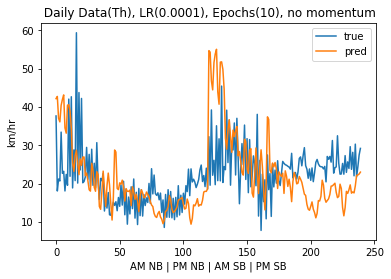

Online Data(Th), LR(0.0001), Epochs(10), no momentum RMSE: 131.90537230239585


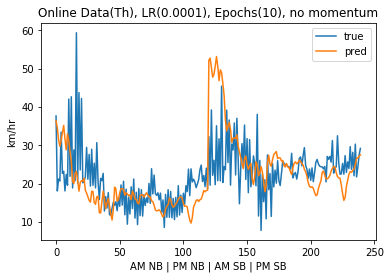

 Daily Data(Th), LR(0.0001), Epochs(10), momentum RMSE: 115.83372413087022


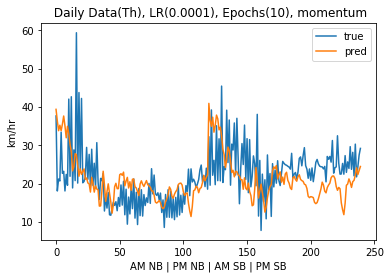

Online Data(Th), LR(0.0001), Epochs(10), momentum RMSE: 149.37620617343202


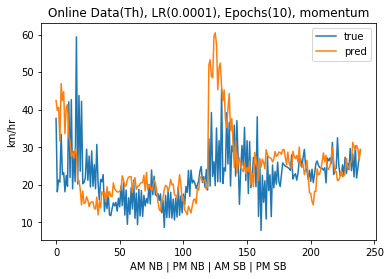

 Daily Data(Th), LR(0.0001), Epochs(10), Nesterov momentum RMSE: 114.89010874561478


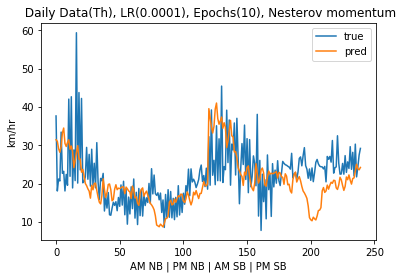

Online Data(Th), LR(0.0001), Epochs(10), Nesterov momentum RMSE: 141.36495199350867


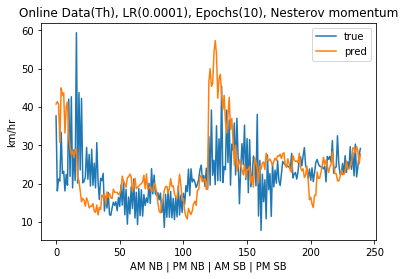

 Daily Data(Wk), LR(0.0001), Epochs(10), no momentum RMSE: 159.35324460211652


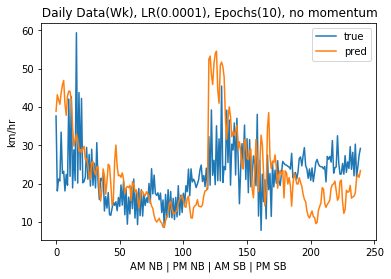

Online Data(Wk), LR(0.0001), Epochs(10), no momentum RMSE: 118.90196287081757


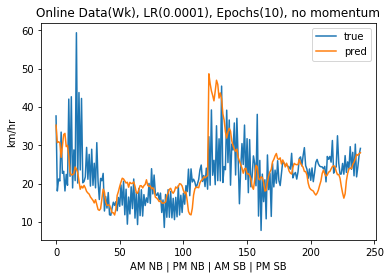

 Daily Data(Wk), LR(0.0001), Epochs(10), momentum RMSE: 152.53383202879525


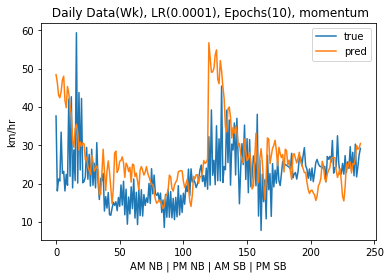

Online Data(Wk), LR(0.0001), Epochs(10), momentum RMSE: 135.87184001774096


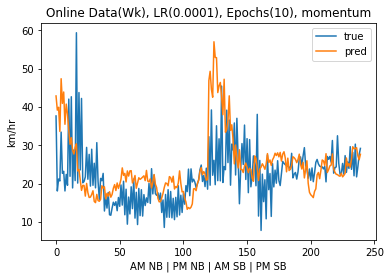

 Daily Data(Wk), LR(0.0001), Epochs(10), Nesterov momentum RMSE: 110.76403820114588


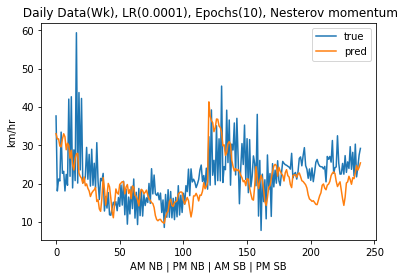

Online Data(Wk), LR(0.0001), Epochs(10), Nesterov momentum RMSE: 138.54314302151573


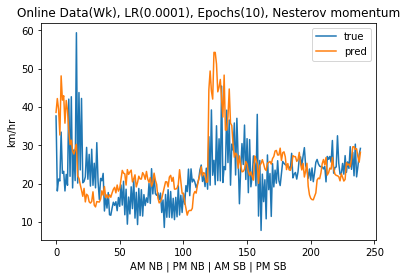

 Daily Data(Th), LR(1e-05), Epochs(10), no momentum RMSE: 157.95616127822507


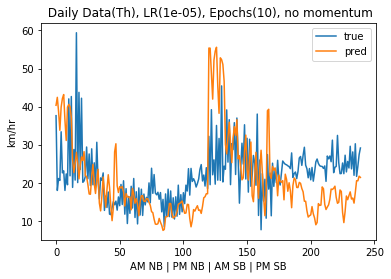

Online Data(Th), LR(1e-05), Epochs(10), no momentum RMSE: 147.96049566646133


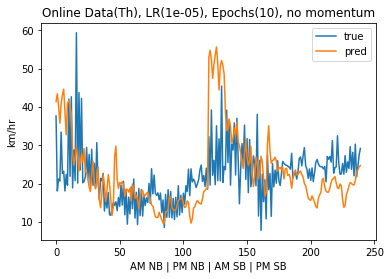

 Daily Data(Th), LR(1e-05), Epochs(10), momentum RMSE: 144.09921816476276


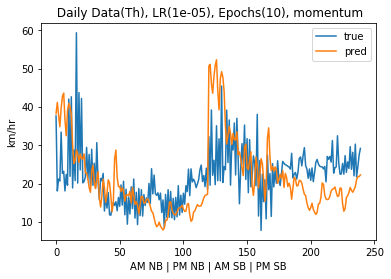

Online Data(Th), LR(1e-05), Epochs(10), momentum RMSE: 137.23142204193803


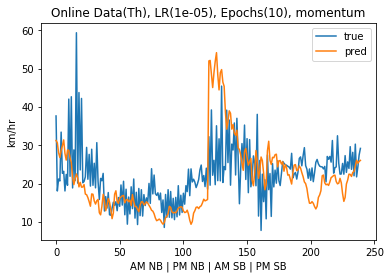

 Daily Data(Th), LR(1e-05), Epochs(10), Nesterov momentum RMSE: 158.46909462563846


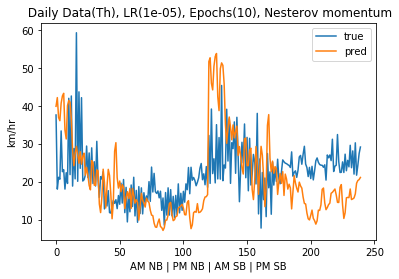

Online Data(Th), LR(1e-05), Epochs(10), Nesterov momentum RMSE: 126.67877583431309


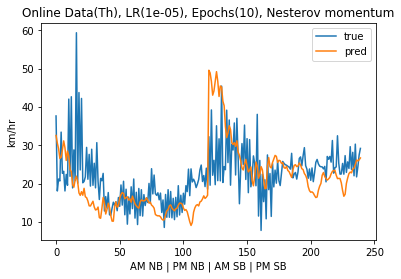

 Daily Data(Wk), LR(1e-05), Epochs(10), no momentum RMSE: 166.16830132538843


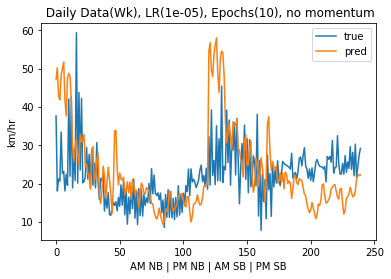

Online Data(Wk), LR(1e-05), Epochs(10), no momentum RMSE: 156.7866994035266


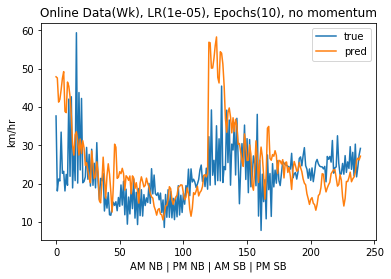

 Daily Data(Wk), LR(1e-05), Epochs(10), momentum RMSE: 168.656536688275


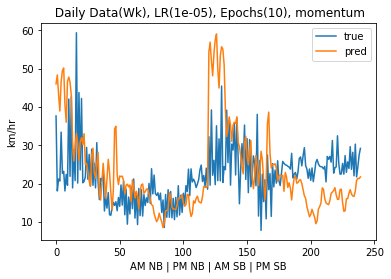

Online Data(Wk), LR(1e-05), Epochs(10), momentum RMSE: 115.89818727719509


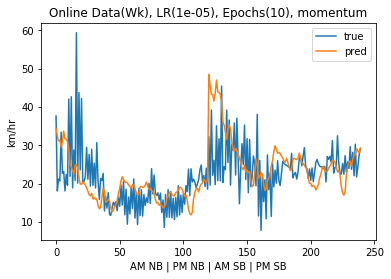

 Daily Data(Wk), LR(1e-05), Epochs(10), Nesterov momentum RMSE: 166.53870646722487


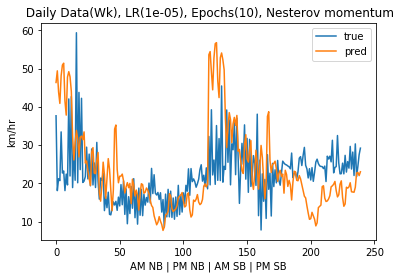

Online Data(Wk), LR(1e-05), Epochs(10), Nesterov momentum RMSE: 123.98682118255128


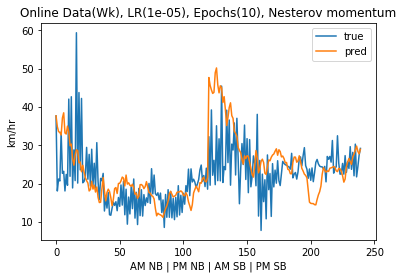

 Daily Data(Th), LR(0.001), Epochs(20), no momentum RMSE: 352.5680095274921


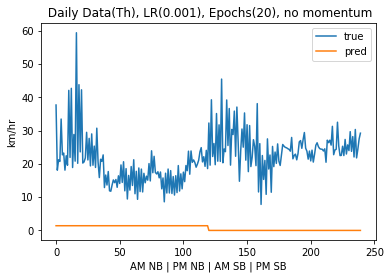

Online Data(Th), LR(0.001), Epochs(20), no momentum RMSE: 320.9399696797331


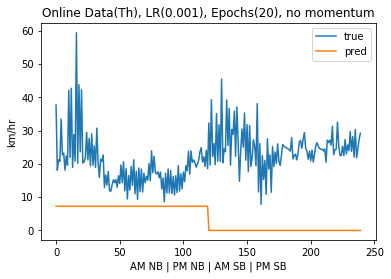

 Daily Data(Th), LR(0.001), Epochs(20), momentum RMSE: 361.48573117571925


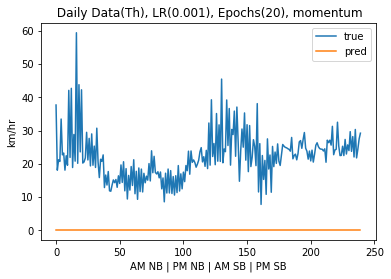

Online Data(Th), LR(0.001), Epochs(20), momentum RMSE: 291.44963366549655


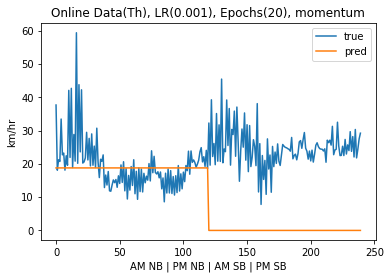

 Daily Data(Th), LR(0.001), Epochs(20), Nesterov momentum RMSE: 361.48573117571925


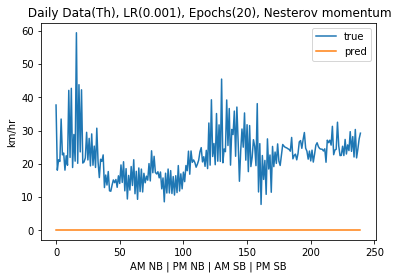

Online Data(Th), LR(0.001), Epochs(20), Nesterov momentum RMSE: 361.48573117571925


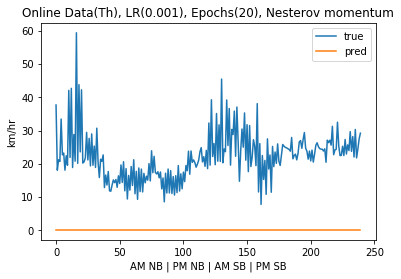

 Daily Data(Wk), LR(0.001), Epochs(20), no momentum RMSE: 361.48573117571925


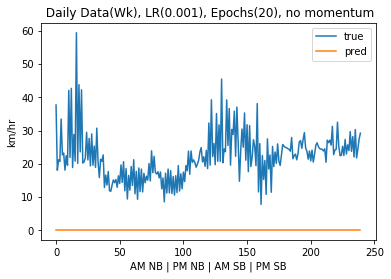

Online Data(Wk), LR(0.001), Epochs(20), no momentum RMSE: 361.48573117571925


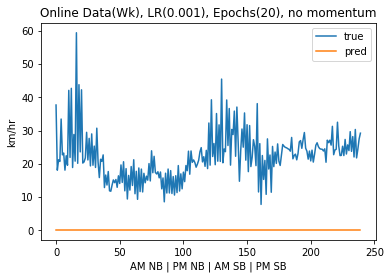

 Daily Data(Wk), LR(0.001), Epochs(20), momentum RMSE: 260.5622487064257


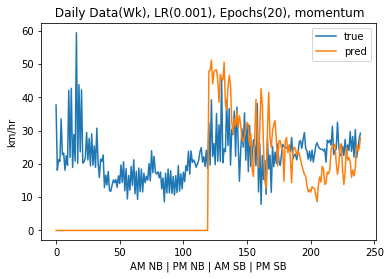

Online Data(Wk), LR(0.001), Epochs(20), momentum RMSE: 237.65411218899933


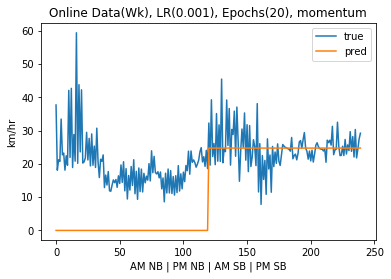

 Daily Data(Wk), LR(0.001), Epochs(20), Nesterov momentum RMSE: 217.01564588173596


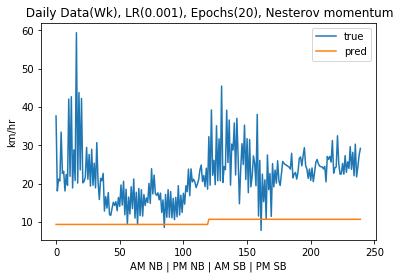

Online Data(Wk), LR(0.001), Epochs(20), Nesterov momentum RMSE: 361.48573117571925


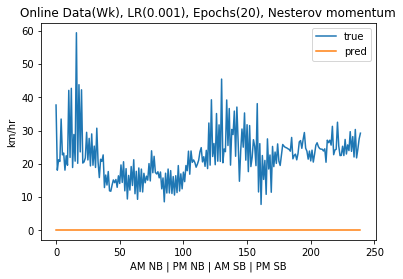

 Daily Data(Th), LR(0.0001), Epochs(20), no momentum RMSE: 139.99958072029392


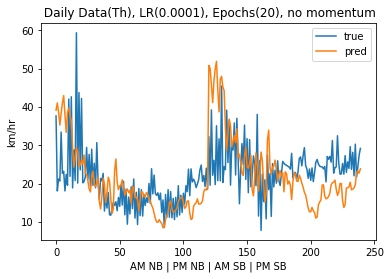

Online Data(Th), LR(0.0001), Epochs(20), no momentum RMSE: 122.73565251565932


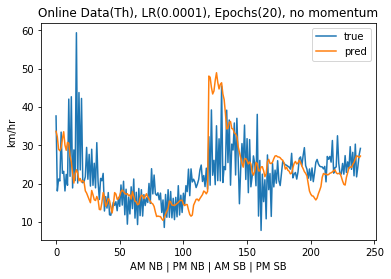

 Daily Data(Th), LR(0.0001), Epochs(20), momentum RMSE: 104.86268521224106


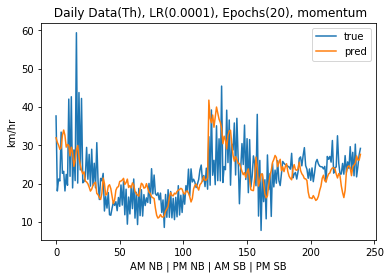

Online Data(Th), LR(0.0001), Epochs(20), momentum RMSE: 144.97553064505604


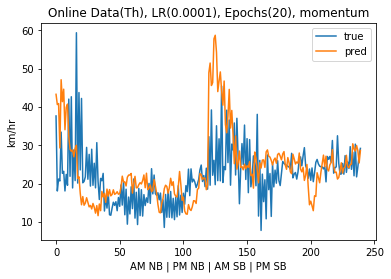

 Daily Data(Th), LR(0.0001), Epochs(20), Nesterov momentum RMSE: 113.41407156272716


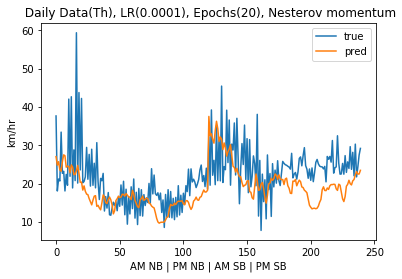

Online Data(Th), LR(0.0001), Epochs(20), Nesterov momentum RMSE: 138.9597402656784


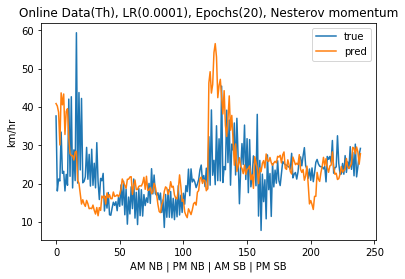

 Daily Data(Wk), LR(0.0001), Epochs(20), no momentum RMSE: 129.01373383829127


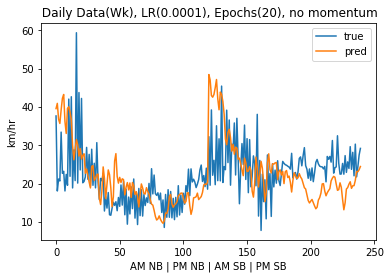

Online Data(Wk), LR(0.0001), Epochs(20), no momentum RMSE: 115.37907276061262


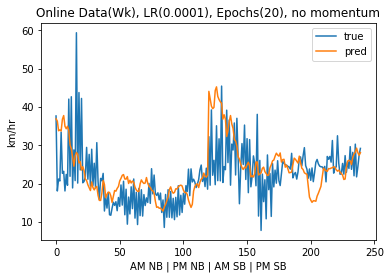

 Daily Data(Wk), LR(0.0001), Epochs(20), momentum RMSE: 114.32328890603937


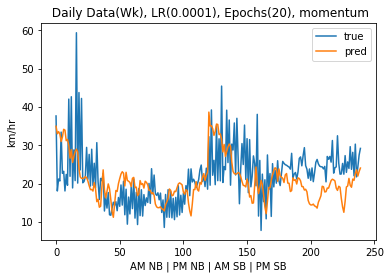

Online Data(Wk), LR(0.0001), Epochs(20), momentum RMSE: 146.72152248191736


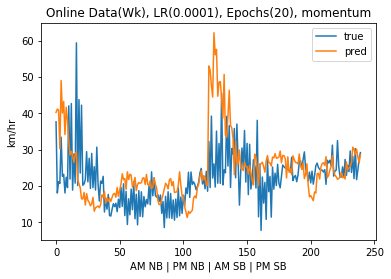

 Daily Data(Wk), LR(0.0001), Epochs(20), Nesterov momentum RMSE: 110.29143637565211


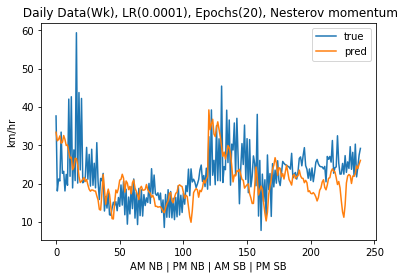

Online Data(Wk), LR(0.0001), Epochs(20), Nesterov momentum RMSE: 140.31858123276368


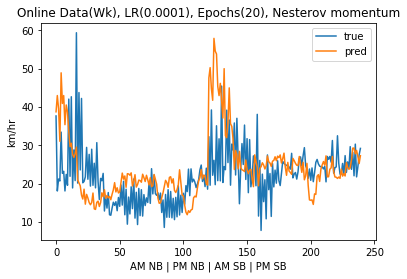

 Daily Data(Th), LR(1e-05), Epochs(20), no momentum RMSE: 151.06727902260658


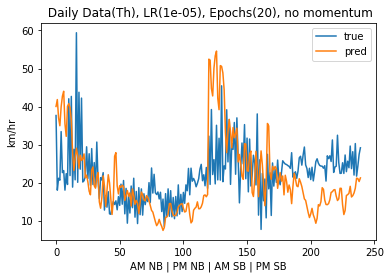

Online Data(Th), LR(1e-05), Epochs(20), no momentum RMSE: 142.36161772747047


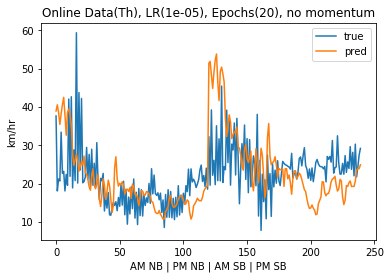

 Daily Data(Th), LR(1e-05), Epochs(20), momentum RMSE: 145.74444093228405


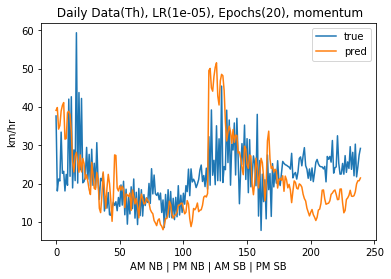

Online Data(Th), LR(1e-05), Epochs(20), momentum RMSE: 124.39981108259066


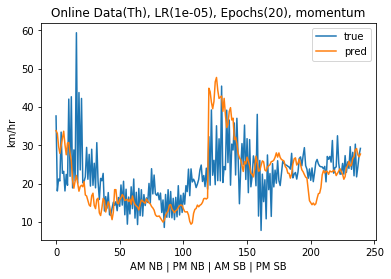

 Daily Data(Th), LR(1e-05), Epochs(20), Nesterov momentum RMSE: 136.9125894132196


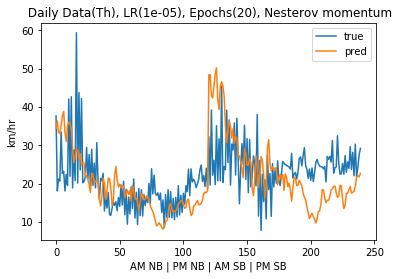

Online Data(Th), LR(1e-05), Epochs(20), Nesterov momentum RMSE: 124.73702819515576


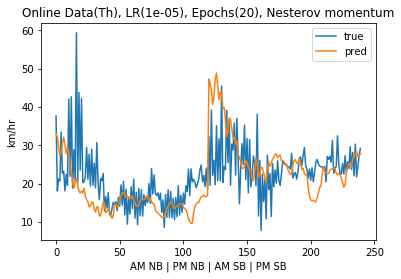

 Daily Data(Wk), LR(1e-05), Epochs(20), no momentum RMSE: 175.7789721778949


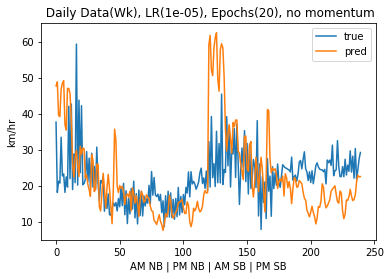

Online Data(Wk), LR(1e-05), Epochs(20), no momentum RMSE: 158.40630711601298


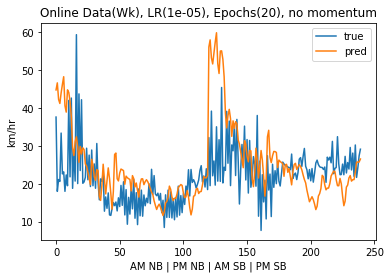

 Daily Data(Wk), LR(1e-05), Epochs(20), momentum RMSE: 145.74099772428988


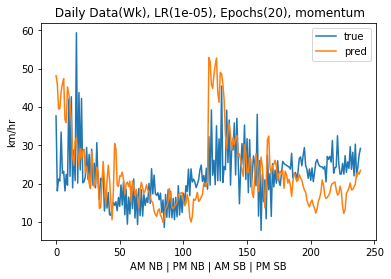

Online Data(Wk), LR(1e-05), Epochs(20), momentum RMSE: 122.42090197775504


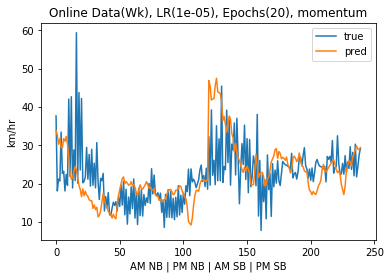

 Daily Data(Wk), LR(1e-05), Epochs(20), Nesterov momentum RMSE: 143.83064753016052


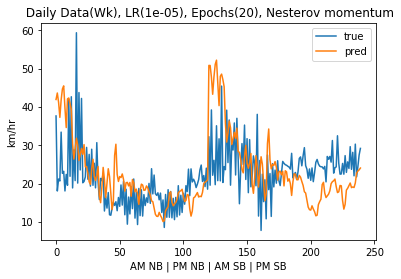

Online Data(Wk), LR(1e-05), Epochs(20), Nesterov momentum RMSE: 128.98990126457886


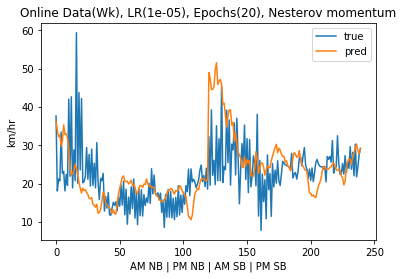

NameError: name 'd' is not defined

In [608]:
results = {}

for epochs in [1, 5, 10, 20]: # test different numbers of epochs
    for lr in [1e-3, 1e-4, 1e-5]: # test different learning rates for gradient descent
        for k,batch in enumerate([all_thu_no_test, two_week_no_test]): # train over (the same number of) MTWTh or just thursdays
            for use_momentum in [False, True]: # determine whether to use momentum values
                for use_nesterov in [False, True]: # determine whether to use normal momentum or nesterov momentum
                    if (not use_momentum) and (use_nesterov):
                        continue

                    description = 'Data({}), LR({}), Epochs({}), {}{}momentum'.format(
                        'Th' if k==0 else 'Wk', lr, epochs, '' if use_momentum else 'no ', 'Nesterov ' if use_nesterov else '')

                    model, _, _, _ = model_using(batch, op='train', epochs=epochs, lr=lr, momentum=0.9*use_momentum, nesterov=use_nesterov, verbose=False)
                    _, rmse, ytrue, ypred = model_using(val_thu,model,op='validate',verbose=False)
                    title = ' Daily {}'.format(description)
                    print('{} RMSE:'.format(title), rmse[-1])
                    plot_comparison(ytrue, ypred, title=title)
                    results[title] = rmse[-1]

                    model, _, _, _ = online_training(batch, epochs=epochs, lr=lr, momentum=0.9*use_momentum, nesterov=use_nesterov, verbose=False)
                    _, rmse, ytrue, ypred = model_using(val_thu,model,op='validate',verbose=False)
                    title = 'Online {}'.format(description)
                    print('{} RMSE:'.format(title), rmse[-1])
                    plot_comparison(ytrue, ypred, title=title)
                    results[title] = rmse[-1]

print('Best model: ', min(results, key=results.get))
best_results = sorted(results.items(), key=lambda kv: kv[1])
for i in range(20):
    print('#{}\tRMSE {}\t\t{}'.format(i+1,best_results[i][1],best_results[i][0]))

In [609]:
print('Best model: ', min(results, key=results.get))
best_results = sorted(results.items(), key=lambda kv: kv[1])
for i in range(20):
    print('#{}\tRMSE {}\t\t{}'.format(i+1,best_results[i][1],best_results[i][0]))

Best model:   Daily Data(Th), LR(0.0001), Epochs(20), momentum
#1	RMSE 106.51288379483859		Online Data(Wk), LR(0.001), Epochs(5), Nesterov momentum
#2	RMSE 110.76403820114588		 Daily Data(Wk), LR(0.0001), Epochs(10), Nesterov momentum
#3	RMSE 114.89010874561478		 Daily Data(Th), LR(0.0001), Epochs(10), Nesterov momentum
#4	RMSE 115.83372413087022		 Daily Data(Th), LR(0.0001), Epochs(10), momentum
#5	RMSE 115.89818727719509		Online Data(Wk), LR(1e-05), Epochs(10), momentum
#6	RMSE 118.90196287081757		Online Data(Wk), LR(0.0001), Epochs(10), no momentum
#7	RMSE 119.0018742714422		Online Data(Wk), LR(0.0001), Epochs(5), Nesterov momentum
#8	RMSE 123.72011246785848		Online Data(Wk), LR(0.0001), Epochs(5), momentum
#9	RMSE 123.98682118255128		Online Data(Wk), LR(1e-05), Epochs(10), Nesterov momentum
#10	RMSE 125.22535503438291		Online Data(Wk), LR(0.0001), Epochs(5), no momentum
#11	RMSE 126.67877583431309		Online Data(Th), LR(1e-05), Epochs(10), Nesterov momentum
#12	RMSE 127.4225644639251

General conclusions
* No far-and-away best performer. In fact our second best model is two staright lines. That hurts.
* Learning rate $10^{-4}$ is the standout winner.
* Training on all weekdays seems as good if not better than Thursdays only, which is good since we have far more weekdays than just Thursday.
* Performance seems to drop off between 10 and 20 epochs.
* Momentum and Nesterov momentum seem to improve results, at least on low epochs, Nesterov possibly moreso than without.

Prescription
* We have more diversity in weekday data and using weekday data doesn't seem to impose a significant penalty, so we'll fit on all weekdays. This dataset is about four times larger so we'll reduce the epochs somewhat to compensate.
* Online models appear in the best list more often but there are more daily models in the top performers so we'll test both. 3 epochs for the former and 5 for the latter.
* Either momentum method seems better than not using momentum.
* Use $10^{-4}$ as learning rate.

 Daily Standard momentum RMSE: 114.08464632702672


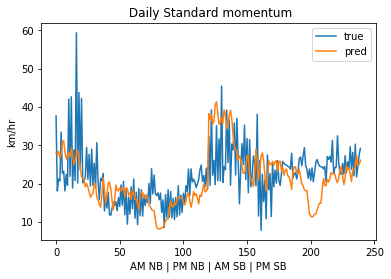

Online Standard momentum RMSE: 138.27796885185342


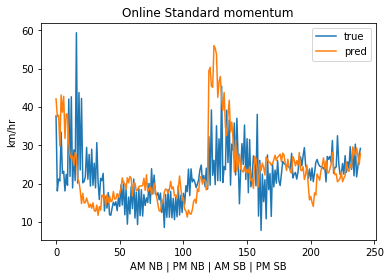

 Daily Nesterov momentum RMSE: 113.52769566265131


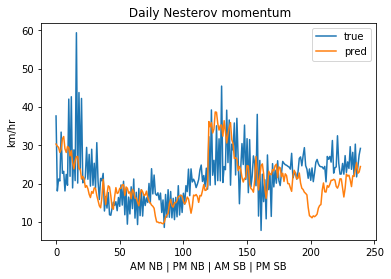

Online Nesterov momentum RMSE: 136.22817989677517


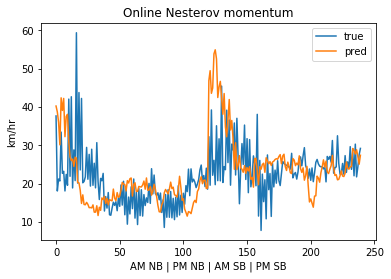

In [623]:
lr = 1e-4
batch = all_weekdays_no_test
use_momentum = True
for use_nesterov in [False, True]: # determine whether to use normal momentum or nesterov momentum

    description = '{} momentum'.format('Nesterov' if use_nesterov else 'Standard')

    model, _, _, _ = model_using(batch, op='train', epochs=5, lr=lr, momentum=0.9, nesterov=use_nesterov, verbose=False)
    _, rmse, ytrue, ypred = model_using(val_thu,model,op='validate',verbose=False)
    title = ' Daily {}'.format(description)
    print('{} RMSE:'.format(title), rmse[-1])
    plot_comparison(ytrue, ypred, title=title)
    results[title] = rmse[-1]

    model, _, _, _ = online_training(batch, epochs=3, lr=lr, momentum=0.9, nesterov=use_nesterov, verbose=False)
    _, rmse, ytrue, ypred = model_using(val_thu,model,op='validate',verbose=False)
    title = 'Online {}'.format(description)
    print('{} RMSE:'.format(title), rmse[-1])
    plot_comparison(ytrue, ypred, title=title)
    results[title] = rmse[-1]

 Daily Standard momentum RMSE: 108.58448510180271


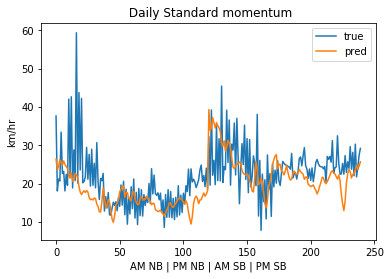

Online Standard momentum RMSE: 143.46263833611584


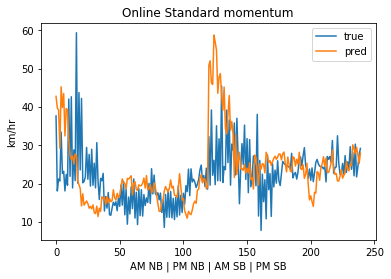

 Daily Nesterov momentum RMSE: 112.562606525203


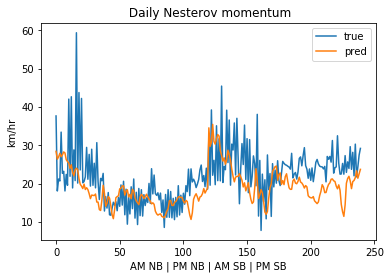

Online Nesterov momentum RMSE: 139.20102539414816


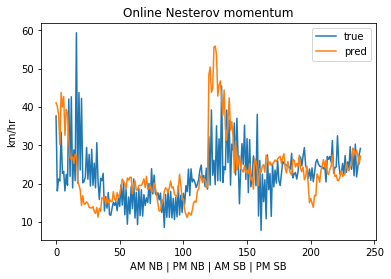

In [624]:
lr = 1e-4
batch = all_weekdays_no_test
use_momentum = True
for use_nesterov in [False, True]: # determine whether to use normal momentum or nesterov momentum

    description = '{} momentum'.format('Nesterov' if use_nesterov else 'Standard')

    model, _, _, _ = model_using(batch, op='train', epochs=10, lr=lr, momentum=0.9, nesterov=use_nesterov, verbose=False)
    _, rmse, ytrue, ypred = model_using(val_thu,model,op='validate',verbose=False)
    title = ' Daily {}'.format(description)
    print('{} RMSE:'.format(title), rmse[-1])
    plot_comparison(ytrue, ypred, title=title)
    results[title] = rmse[-1]

    model, _, _, _ = online_training(batch, epochs=5, lr=lr, momentum=0.9, nesterov=use_nesterov, verbose=False)
    _, rmse, ytrue, ypred = model_using(val_thu,model,op='validate',verbose=False)
    title = 'Online {}'.format(description)
    print('{} RMSE:'.format(title), rmse[-1])
    plot_comparison(ytrue, ypred, title=title)
    results[title] = rmse[-1]

 Daily Nesterov momentum RMSE: 107.23899569131513


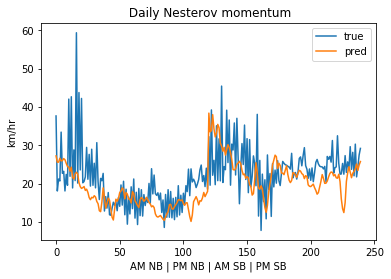

In [678]:
model, _, _, _ = model_using(batch, op='train', epochs=10, lr=1e-4, momentum=0.9, verbose=False)
_, rmse, ytrue, ypred = model_using(val_thu,model,op='validate',verbose=False)
title = ' Daily {}'.format(description)
print('{} RMSE:'.format(title), rmse[-1])
plot_comparison(ytrue, ypred, title=title)

The above seems to be our best model so far. 10 epochs, introducing momentum to our gradient descent without using the Nesterov method, with a learning rate of $10^{-4}$. 

## Split AM/PM

Would performance improve if we fit separate models on AM and PM periods?

In [694]:
def validate_split(dates, modelam, modelpm, test=False, verbose=True):
    # if testing or validating split am/pm model, model is am model, model_pm is pm model
    # momentum, dampening, weight_decay, and nesterov are all from the pytorch implementation of stochastic gradient descent (SGD)
    
    models = [modelam, modelpm]
    ampm = ['am', 'pm']
    
    # Construct our loss function and an Optimizer. The call to model.parameters()
    # in the SGD constructor will contain the learnable parameters of the two
    # nn.Linear modules which are members of the model.
    criterion = torch.nn.MSELoss(reduction='sum')
#     amoptimizer = torch.optim.SGD(model.parameters(), lr, momentum=momentum, dampening=dampening, weight_decay=weight_decay, nesterov=nesterov)
#     pmoptimizer = 
    
    rmse = []
    
    daily_ytrues = []
    daily_predictions = []

    for date in dates:

        # collect results
        nb_preds = []
        sb_preds = []    

        ytrue = []

        # update weights only after a full day has been fitted
        for k,m in enumerate(ampm): 
            model = models[k]

            # read in data
            dfy = pd.read_pickle('data/processed/{}-{}_y_{}.pkl'.format(date[0],date[1],m))
            dfy = dfy.iloc[:-1,:] # drop last row

            dfn = pd.read_pickle('data/processed/{}-{}_n_{}.pkl'.format(date[0],date[1],m))
            dfs = pd.read_pickle('data/processed/{}-{}_s_{}.pkl'.format(date[0],date[1],m))
            dfew = pd.read_pickle('data/processed/{}-{}_ew_{}.pkl'.format(date[0],date[1],m))
            dfn = pd.read_pickle('data/processed/{}-{}_n_{}.pkl'.format(date[0],date[1],m))
            dfs = pd.read_pickle('data/processed/{}-{}_s_{}.pkl'.format(date[0],date[1],m))
            dfew = pd.read_pickle('data/processed/{}-{}_ew_{}.pkl'.format(date[0],date[1],m))

            # set first t-1 (tm1) 
            nb_moves_tm1 = torch.tensor(dfn.values[0,:])
            sb_moves_tm1 = torch.tensor(dfs.values[0,:])
            ew_moves_tm1 = torch.tensor(dfew.values[0,:])
            nb_hat_tm1 = torch.tensor([dfy.values[0,0]]).double()
            sb_hat_tm1 = torch.tensor([dfy.values[0,1]]).double()

            # drop first entry and convert y of true values to tensor
            if not test:
                dfy = dfy.iloc[1:,:]
                ytrue.append(dfy.values)

            for i in range(1,61): # fixed five-hour period cut into 5 minute chunks

                # get data
                nb_moves_t = torch.tensor(dfn.values[i,:])
                sb_moves_t = torch.tensor(dfs.values[i,:])
                ew_moves_t = torch.tensor(dfew.values[i,:])

                # fit model
                nb_pred, sb_pred = model(
                    nb_moves_t, 
                    nb_moves_tm1, 
                    sb_moves_t, 
                    sb_moves_tm1, 
                    ew_moves_t, 
                    ew_moves_tm1,
                    nb_hat_tm1, 
                    sb_hat_tm1
                )

                # collect predictions
                nb_preds.append(nb_pred)
                sb_preds.append(sb_pred)

                # set next set of (t-1) values
                nb_moves_tm1 = nb_moves_t
                sb_moves_tm1 = sb_moves_t
                ew_moves_tm1 = ew_moves_t
                nb_hat_tm1 = nb_pred
                sb_hat_tm1 = sb_pred


        preds = torch.cat(nb_preds+sb_preds)
        if not test:
            ytrue = torch.tensor(np.stack(ytrue).T.flatten())

            loss = torch.sqrt(criterion(preds, ytrue))

            rmse.append(loss.item())

            daily_ytrues.append(ytrue.detach().numpy())
        daily_predictions.append(preds.detach().numpy())
   
    if not test:
        return model, rmse, daily_ytrues, daily_predictions
    else:
        return daily_predictions

 Daily Nesterov momentum RMSE: 111.1346731844373


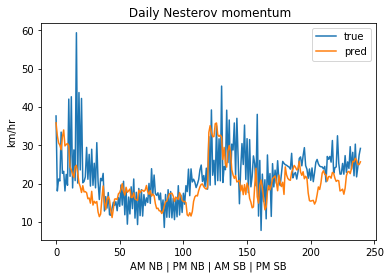

In [695]:
lr = 1e-4
epochs = 10
use_nesterov = False
modelam, _, _, _ = model_using(batch, op='train', epochs=epochs, lr=lr, momentum=0.9, nesterov=use_nesterov, pm=False, verbose=False)
modelpm, _, _, _ = model_using(batch, op='train', epochs=epochs, lr=lr, momentum=0.9, nesterov=use_nesterov, am=False, verbose=False)
_, rmse, ytrue, ypred = validate_split(val_thu,modelam,modelpm,verbose=False)
title = ' Daily {}'.format(description)
print('{} RMSE:'.format(title), rmse[-1])
plot_comparison(ytrue, ypred, title=title)

Online Nesterov momentum RMSE: 107.47495938003067


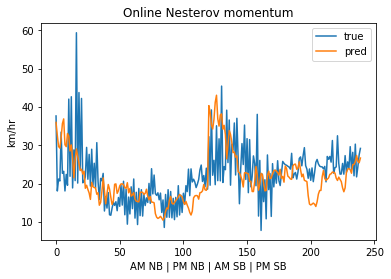

In [698]:
lr = 1e-4
epochs = 1
use_nesterov = True
modelam, _, _, _ = online_training(batch, op='train', epochs=epochs, lr=lr, momentum=0.9, nesterov=use_nesterov, pm=False, verbose=False)
modelpm, _, _, _ = online_training(batch, op='train', epochs=epochs, lr=lr, momentum=0.9, nesterov=use_nesterov, am=False, verbose=False)
_, rmse, ytrue, ypred = validate_split(val_thu,modelam,modelpm,verbose=False)
title = 'Online {}'.format(description)
print('{} RMSE:'.format(title), rmse[-1])
plot_comparison(ytrue, ypred, title=title)

Our "online" model seems to perform better when we split AM and PM models.

# Final model candidates

We'll use two models to predict results:
1. The standard/"offline" model trained over 10 epochs, with momentum calculations turned on.
2. The "online" model trained on the full dataset only once, with momentum calculations using the Nesterov method.

Both will be trained over all Monday-Thursday weekdays we have available with a learning rate of $10^{-4}$.

 Daily Nesterov momentum RMSE: 105.72078279979895


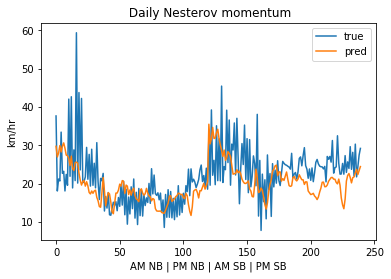

Online Nesterov momentum RMSE: 124.68304199848231


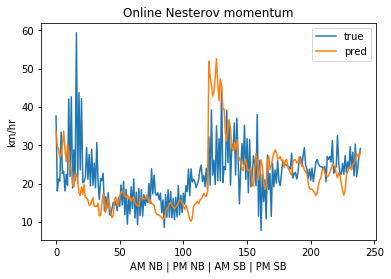

CPU times: user 1min 1s, sys: 891 ms, total: 1min 2s
Wall time: 1min 2s


In [700]:
%%time
test_date = [('12','01')]

model_static, _, _, _ = model_using(all_weekdays, op='train', epochs=10, lr=1e-4, momentum=0.9, verbose=False)
_, rmse, ytrue, ypred = model_using(val_thu, model_static, op='validate', verbose=False)
title = ' Daily {}'.format(description)
print('{} RMSE:'.format(title), rmse[-1])
plot_comparison(ytrue, ypred, title=title)

model_online_am, _, _, _ = online_training(all_weekdays, op='train', epochs=1, lr=1e-4, momentum=0.9, nesterov=True, pm=False, verbose=False)
model_online_am, _, _, _ = online_training(all_weekdays, op='train', epochs=1, lr=1e-4, momentum=0.9, nesterov=True, am=False, verbose=False)
_, rmse, ytrue, ypred = validate_split(val_thu, model_online_am, model_online_am, verbose=False)
title = 'Online {}'.format(description)
print('{} RMSE:'.format(title), rmse[-1])
plot_comparison(ytrue, ypred, title=title)

Interestingly, the online model seems to do worse on the validation day after it's fitted on the validation day. Perhaps it's similar to a time-moving average?

In [765]:
ypred_static = model_using(test_date, model_static, op='test',verbose=False)
ypred_online = validate_split(test_date, model_online_am, model_online_am, test=True, verbose=False)
np.savetxt('Predictions/static_pred.csv', ypred_static,delimiter='\n')
np.savetxt('Predictions/online_pred.csv', ypred_online,delimiter='\n')

Done! Now visualize.

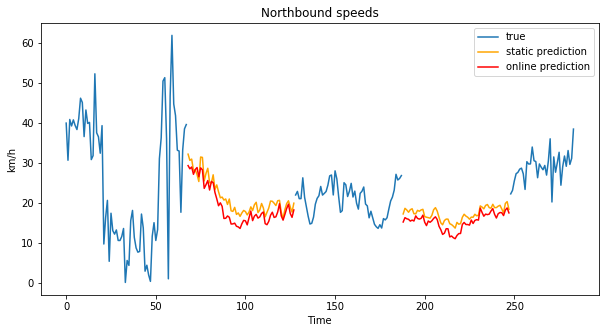

In [762]:
bb5minNtrue = pd.read_csv('Predictions/Predictions_north.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%I:%M:%S %p').replace(year=2016,month=12,day=1))
bb5minNtrue['speed'] = bb5minNtrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minNtrue.index = bb5minNtrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(10,5))
plt.plot(bb5minNtrue['speed'].values,label='true')
plt.plot(np.array(range(68,128)),ypred_static[0][0:60],color='orange',label='static prediction')
plt.plot(np.array(range(188,248)),ypred_static[0][60:120],color='orange')
plt.plot(np.array(range(68,128)),ypred_online[0][0:60],color='red',label='online prediction')
plt.plot(np.array(range(188,248)),ypred_online[0][60:120],color='red')
plt.legend()
plt.xlabel('Time')
plt.title('Northbound speeds')
plt.ylabel('km/h')
plt.savefig('Predictions_north.png')
plt.show()

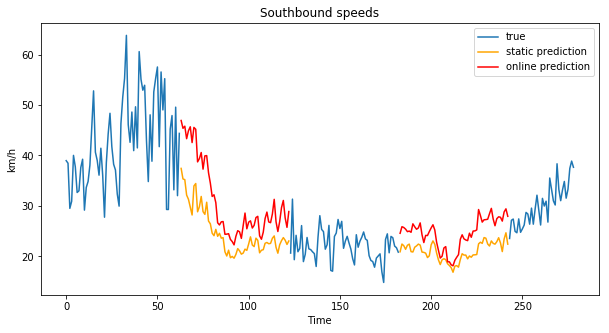

In [763]:
bb5minStrue = pd.read_csv('Predictions/Predictions_south.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%H:%M:%S').replace(year=2016,month=12,day=1))
bb5minStrue['speed'] = bb5minStrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minStrue.index = bb5minStrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(10,5))
plt.plot(bb5minStrue['speed'].values,label='true')
plt.plot(np.array(range(63,123)),ypred_static[0][120:180],color='orange',label='static prediction')
plt.plot(np.array(range(183,243)),ypred_static[0][180:240],color='orange')
plt.plot(np.array(range(63,123)),ypred_online[0][120:180],color='red',label='online prediction')
plt.plot(np.array(range(183,243)),ypred_online[0][180:240],color='red')
plt.legend()
plt.xlabel('Time')
plt.title('Southbound speeds')
plt.ylabel('km/h')
plt.savefig('Predictions_south.png')
plt.show()

Verification of CSVs to submit.

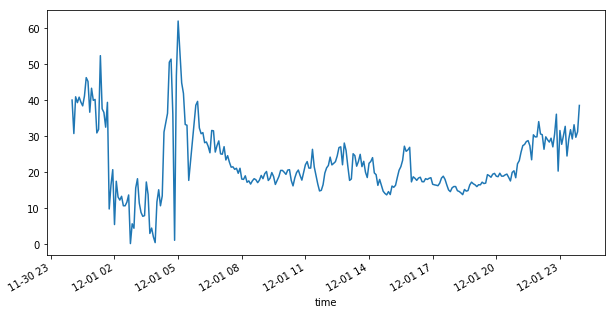

In [776]:
bb5minNtrue = pd.read_csv('Predictions/Predictions_north_SPARTA_static.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%I:%M:%S %p').replace(year=2016,month=12,day=1))
bb5minNtrue['speed'] = bb5minNtrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minNtrue.index = bb5minNtrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(10,5))
bb5minNtrue['speed'].plot()
plt.show()

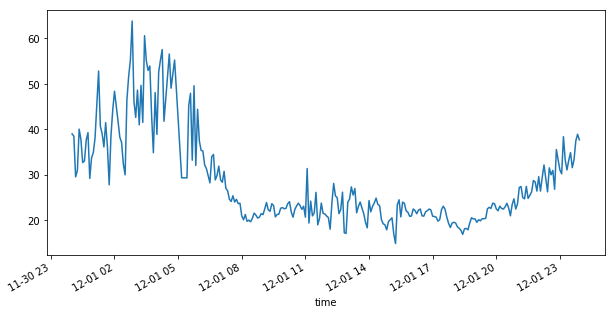

In [778]:
bb5minStrue = pd.read_csv('Predictions/Predictions_south_SPARTA_static.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%H:%M:%S').replace(year=2016,month=12,day=1))
bb5minStrue['speed'] = bb5minStrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minStrue.index = bb5minStrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(10,5))
bb5minStrue['speed'].plot()
plt.show()

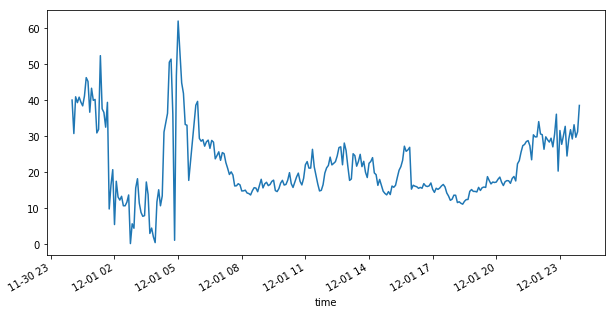

In [774]:
bb5minNtrue = pd.read_csv('Predictions/Predictions_north_SPARTA_online.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%I:%M:%S %p').replace(year=2016,month=12,day=1))
bb5minNtrue['speed'] = bb5minNtrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minNtrue.index = bb5minNtrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(10,5))
bb5minNtrue['speed'].plot()
plt.show()

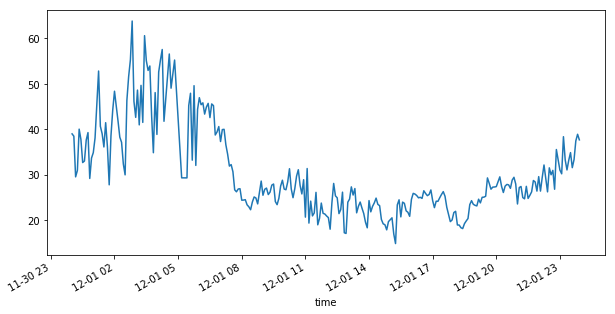

In [775]:
bb5minStrue = pd.read_csv('Predictions/Predictions_south_SPARTA_online.csv',index_col='time',parse_dates=True,infer_datetime_format=True,
                          date_parser= lambda x: pd.datetime.strptime(x, '%H:%M:%S').replace(year=2016,month=12,day=1))
bb5minStrue['speed'] = bb5minStrue['speed'].apply(pd.to_numeric, errors='coerce')
bb5minStrue.index = bb5minStrue.index.tz_localize('Asia/Shanghai')
plt.figure(figsize=(10,5))
bb5minStrue['speed'].plot()
plt.show()